# 3º Notebook - Aplicação da Teoria de Markowitz

Neste notebook vamos tentar aplicar a Teoria de Markowitz. Gostaria de referenciar o material de motivação e explicação do conteúdo: [vídeo da T2 Educação](https://www.youtube.com/watch?v=i5WCpU07_yo).

Algumas coisas que serão feitas: primeiro vamos puxar os dados de cotação dos ativos e do Ibovespa. Algumas funções serão explicadas, como por exemplo o cálculo da rentabilidade e do risco, visto que haverá uma normalização nesses cálculos.

Além disso, para procurar a melhor composição de pesos, ao invés de testar de maneira bruta os pesos, vamos utilizar a ideia da busca bayesiana, muito utilizada na busca de hiperparâmetros de modelos. Essa busca vai tentar localizar a melhor composição de peso para os ativos. Depois vamos analisar a carteira escolhida e também como as cotações se comportam entre si.

Também vamos verificar algumas melhorias, como por exemplo filtrar ainda mais a carteira escolhida com a exclusão dos ativos com base na correlação. Enfim, vamos explicar aos poucos cada passo e as decisões tomadas.


In [1]:
# Imports
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Configurando para aparecer todas as colunas do dataframe pandas
pd.set_option('display.max_columns', None)

In [3]:
# Importandos os dados

# Dados de Peso de Participacao
df_participacao = pd.read_csv('data/participacao_ativos.csv', encoding='ISO-8859-1')

display(df_participacao)

,Ativo,Ano Fundacao,Ano IPO,Valor Mercado,Setor,Segmento,Idade,Tempo em Bolsa,Peso Participacao,EmpresaIPO,ClassEmpresa
0,VALE3,1943,1970,223954633000,Materiais Básicos,Minerais Metálicos,82,55,11.595,Consolidada,Large Caps
1,ITUB4,1943,2002,313335024000,Financeiro,Bancos,82,23,7.925,Consolidada,Large Caps
2,PETR4,1953,1977,426601191000,"Petróleo, Gás e Biocombustíveis","Exploração, Refino e Distribuição",72,48,7.884,Consolidada,Large Caps
3,PETR3,1953,1977,426601191000,"Petróleo, Gás e Biocombustíveis","Exploração, Refino e Distribuição",72,48,4.409,Consolidada,Large Caps
4,ELET3,1962,1971,98986984000,Utilidade Pública,Energia Elétrica,63,54,3.862,Consolidada,Mid Caps
...,...,...,...,...,...,...,...,...,...,...,...
82,PETZ3,2013,2020,1776090000,Consumo não Cíclico,Produtos Diversos,12,5,0.058,Recente,Small Caps
83,CVCB3,2009,2013,1035414000,Consumo Cíclico,Viagens e Turismo,16,12,0.053,Normal,Small Caps
84,AZUL4,2008,2017,986716000,Bens Industriais,Transporte Aéreo,17,8,0.051,Recente,Small Caps
85,LWSA3,1997,2020,1502906000,Tecnologia da Informação,Programas e Serviços,28,5,0.050,Recente,Small Caps


In [4]:
# Dados de cotacao
df_percentual = pd.read_csv('data/cotacao_ativos_atualizada.csv', encoding='ISO-8859-1')

display(df_percentual)

,Date,Cotacao,Ativo,Percentual,Ano,Mes,Mes_Ano,Peso Participacao,Percentual Ponderado
0,2008-01-02,25.14,VALE3,0.0243,2008,1,2008-01,0.11595,0.002818
1,2008-01-03,25.27,VALE3,-0.0051,2008,1,2008-01,0.11595,-0.000591
2,2008-01-04,24.36,VALE3,0.0374,2008,1,2008-01,0.11595,0.004337
3,2008-01-07,23.92,VALE3,0.0184,2008,1,2008-01,0.11595,0.002133
4,2008-01-08,24.40,VALE3,-0.0197,2008,1,2008-01,0.11595,-0.002284
...,...,...,...,...,...,...,...,...,...
223422,2024-12-20,2.41,PCAR3,-0.0249,2024,12,2024-12,0.00068,-0.000017
223423,2024-12-23,2.43,PCAR3,-0.0082,2024,12,2024-12,0.00068,-0.000006
223424,2024-12-26,2.56,PCAR3,-0.0508,2024,12,2024-12,0.00068,-0.000035
223425,2024-12-27,2.59,PCAR3,-0.0116,2024,12,2024-12,0.00068,-0.000008


In [5]:
# Dados do IBOV
df_ibov = pd.read_csv('data/cotacao_IBOV_atualizada.csv', encoding='ISO-8859-1')

display(df_ibov)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Percentual,Ano
0,2008-01-02,63885.0,63906.0,62659.0,62815.0,2980200,0.0,0.0,0.017050,2008
1,2008-01-03,62814.0,63129.0,62556.0,62892.0,1895800,0.0,0.0,-0.001224,2008
2,2008-01-04,62898.0,63436.0,60574.0,61037.0,2613800,0.0,0.0,0.030391,2008
3,2008-01-07,61054.0,61505.0,60092.0,60772.0,2223400,0.0,0.0,0.004361,2008
4,2008-01-08,60771.0,62650.0,60771.0,62081.0,3314000,0.0,0.0,-0.021085,2008
...,...,...,...,...,...,...,...,...,...,...
4205,2024-12-20,121183.0,122209.0,120700.0,122102.0,18128200,0.0,0.0,-0.007486,2024
4206,2024-12-23,122105.0,122105.0,120617.0,120767.0,9953300,0.0,0.0,0.011054,2024
4207,2024-12-26,120767.0,121612.0,120428.0,121078.0,8338500,0.0,0.0,-0.002569,2024
4208,2024-12-27,121078.0,121609.0,120252.0,120269.0,8937000,0.0,0.0,0.006727,2024


# 1. Tratando os Dados

In [6]:
# Pivotar as tabelas para deixar os ativos em colunas
df_percentual_ativos = df_percentual.pivot_table(index='Date', columns='Ativo', values='Percentual')

# Valores NaN sendo substituidos por valor zero, por não ter a cotação do dia
df_percentual_ativos = df_percentual_ativos.fillna(0)

# Arredondando para apenas 4 casas decimais
df_percentual_ativos  = df_percentual_ativos.round(4)

# Atribuindo a coluna Date
df_percentual_ativos = df_percentual_ativos.reset_index()

# Igualar as datas do IBOV com as datas do ativo
df_percentual_ativos = df_percentual_ativos[df_percentual_ativos['Date'].isin(df_ibov['Date'])].copy()

# Resetando o indice já que filtramos alguns indices
df_percentual_ativos = df_percentual_ativos.reset_index(drop=True)

display(df_percentual_ativos)

Ativo,Date,ABEV3,B3SA3,BBAS3,BBDC3,BBDC4,BEEF3,BRAP4,BRFS3,BRKM5,CCRO3,CMIG4,CPFE3,CPLE6,CSAN3,CSNA3,CYRE3,EGIE3,ELET3,ELET6,EMBR3,ENEV3,EQTL3,GGBR4,GOAU4,HYPE3,ISAE4,ITSA4,ITUB4,JBSS3,LREN3,MRFG3,MRVE3,MULT3,PCAR3,PETR3,PETR4,POMO4,PSSA3,RADL3,RENT3,SBSP3,SLCE3,SMTO3,SUZB3,TAEE11,TIMS3,TOTS3,UGPA3,USIM5,VALE3,VIVT3,WEGE3,YDUQ3
0,2008-01-02,0.0144,0.0286,0.0209,0.0721,0.0000,0.0335,0.0000,0.0437,0.0211,-0.0194,0.0000,0.0120,0.0092,-0.0065,0.0164,0.0206,0.0388,0.0270,0.0000,0.0024,0.0223,0.0000,0.0000,0.0367,0.0000,0.0625,0.1438,0.0459,0.0081,0.0129,0.0010,-0.0113,0.0340,0.0000,0.0068,0.0161,0.0093,0.0440,0.1029,0.0601,-0.0116,0.0067,-0.0022,0.0000,0.0818,0.0000,-0.0139,0.0000,0.0000,0.0243,0.0471,0.0115,0.0000
1,2008-01-03,-0.0036,0.0107,0.0154,0.0110,0.0206,-0.0349,0.0333,-0.0045,0.0080,0.0256,0.0054,-0.0074,-0.0268,-0.0161,-0.0208,0.0093,0.0131,0.0088,0.0108,-0.0196,0.0066,0.0000,0.0000,-0.0233,0.0000,0.0000,0.0139,0.0187,0.0165,0.0131,-0.0010,0.0032,-0.0675,0.0000,0.0145,0.0164,0.0000,0.0236,-0.0145,-0.0394,-0.0271,0.0068,0.0022,0.0000,-0.0717,0.0000,-0.0035,0.0000,0.0074,-0.0051,0.0047,0.0000,0.0000
2,2008-01-04,0.0146,0.0891,0.0117,-0.0195,0.0123,0.0113,0.0420,0.0364,0.0429,0.0445,0.0222,0.0353,0.0467,0.0032,0.0332,0.0212,0.0000,0.0104,0.0065,0.0052,0.0204,0.0000,0.0000,0.0263,0.0000,0.0000,0.0035,-0.0072,0.0111,0.0160,0.0000,0.0282,0.0223,0.0000,0.0631,0.0517,-0.0092,0.0130,0.0147,0.0496,0.0195,-0.0199,-0.0085,0.0000,-0.0084,0.0316,0.0248,0.0000,0.0305,0.0374,0.0300,0.0039,0.0000
3,2008-01-07,0.0224,0.0546,-0.0229,-0.0107,-0.0186,0.0000,0.0092,-0.0308,-0.0137,-0.0232,-0.0055,0.0015,0.0000,-0.0578,0.0343,0.0000,-0.0629,-0.0125,-0.0171,0.0047,-0.0101,0.0000,0.0000,0.0277,0.0000,0.0000,0.0000,0.0000,0.0028,0.0621,0.0073,0.0361,0.0445,0.0000,0.0357,0.0308,0.0381,0.0132,0.0303,0.0401,0.0105,0.0067,-0.0526,0.0000,0.0042,0.0021,0.0483,0.0000,0.0509,0.0184,-0.0016,-0.0038,0.0000
4,2008-01-08,-0.0147,-0.0406,-0.0206,-0.0210,-0.0146,-0.0063,0.0000,-0.0022,-0.0014,-0.0336,0.0000,-0.0015,-0.0093,-0.0464,-0.0188,-0.0553,0.0187,-0.0007,-0.0021,-0.0023,0.0000,0.0000,0.0000,0.0070,0.0000,0.0000,-0.0103,-0.0092,0.0229,0.0412,-0.0031,-0.0068,-0.0126,0.0000,-0.0567,-0.0523,-0.0278,0.0202,0.0312,0.0295,-0.0023,0.0000,-0.0714,0.0000,0.0000,0.0000,0.0151,0.0000,0.0000,-0.0197,-0.0008,0.0277,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4205,2024-12-20,0.0446,-0.0276,-0.0079,-0.0224,-0.0215,-0.0018,0.0000,-0.0030,0.0328,-0.0173,-0.0215,-0.0157,-0.0096,-0.0270,-0.0054,-0.0217,-0.0133,-0.0114,-0.0171,0.0184,-0.0116,-0.0083,0.0063,-0.0055,-0.0446,-0.0156,-0.0156,-0.0112,0.0224,-0.0314,-0.0256,-0.0054,-0.0307,-0.0249,0.0073,0.0084,0.0259,0.0118,-0.0026,-0.0337,0.0066,0.0005,-0.0247,0.0181,-0.0175,-0.0087,-0.0022,-0.0158,0.0166,-0.0156,-0.0099,0.0165,-0.0460
4206,2024-12-23,0.0008,0.0010,0.0067,0.0159,0.0182,0.0184,0.0072,0.0123,0.0322,0.0266,0.0401,0.0387,0.0298,-0.0023,0.0497,0.0381,0.0337,0.0139,0.0160,-0.0106,0.0446,0.0424,0.0257,0.0417,-0.0321,0.0236,0.0134,0.0196,0.0081,0.0636,0.0084,0.0532,0.0371,-0.0082,-0.0075,-0.0003,0.0367,0.0105,0.0058,0.0243,-0.0201,0.0268,0.0427,-0.0265,0.0319,0.0066,-0.0047,0.0129,0.0363,-0.0042,0.0336,0.0225,0.0333
4207,2024-12-26,0.0067,-0.0069,-0.0116,-0.0108,-0.0081,0.0421,0.0012,0.0220,0.0017,-0.0039,-0.0129,-0.0060,-0.0033,0.0215,-0.0045,0.0135,0.0011,-0.0062,-0.0087,-0.0123,0.0028,0.0040,0.0027,0.0048,0.0267,-0.0009,-0.0108,-0.0064,0.0005,0.0033,-0.0101,-0.0150,0.0162,-0.0508,0.0188,0.0305,0.0014,0.0120,0.0036,0.0109,-0.0018,0.0119,0.0126,-0.0113,-0.0076,0.0193,0.0121,0.0227,-0.0095,-0.0028,-0.0079,-0.0077,0.0206
4208,2024-12-27,0.0059,-0.0029,0.0037,0.0069,0.0082,0.0077,0.0066,0.0270,0.0208,-0.0029,0.0009,-0.0019,-0.0087,0.0245,0.0253,-0.0018,0.0180,-0.0012,-0.0011,-0.0016,0.0180,0.0065,0.0203,0.0244,0.0074,0.0043,0.0073,0.0100,0.0

In [7]:
# Retirando algumas colunas que não vai precisar no df_ibov
df_ibov = df_ibov.drop(columns=['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'])

display(df_ibov)

,Date,Close,Percentual,Ano
0,2008-01-02,62815.0,0.017050,2008
1,2008-01-03,62892.0,-0.001224,2008
2,2008-01-04,61037.0,0.030391,2008
3,2008-01-07,60772.0,0.004361,2008
4,2008-01-08,62081.0,-0.021085,2008
...,...,...,...,...
4205,2024-12-20,122102.0,-0.007486,2024
4206,2024-12-23,120767.0,0.011054,2024
4207,2024-12-26,121078.0,-0.002569,2024
4208,2024-12-27,120269.0,0.006727,2024


# 2. Calculo do Retorno e Risco

**Cálculo da Rentabilidade/Risco dos Ativos**

Para o cálculo da Rentabilidade utilizamos a *média* dos percentuais. Entretanto, temos diversos ativos e a própria cotação do Ibovespa. É claro que, na seção anterior, com o tratamento dos dados, já deixamos todos no mesmo período, todos correspondendo às mesmas datas. Acontece que, para comparar diversos ativos e deixar a análise mais sólida, podemos normalizar ou padronizar o cálculo. Essa normalização/padronização é chamada de **Rentabilidade Anualizada**. Claro que o parâmetro da função `periodo_dias` pode ser padronizado em outros períodos como semestral, trimestral, mensal, enfim, fica a critério. No vídeo utiliza-se o período anual. Assim, a Rentabilidade será anualizada, mas o risco também, tendo portanto o **Risco Anualizado**.

Outra curiosidade é que o período de dias para anualização é de 252 dias, esta é a média de dias com operação em um ano, ou seja, em um ano, tem 252 dias de operação. Por isso vamos anualizar neste período de dias.

Abaixo estão as fórmulas da Rentabilidade e Risco Anualizados sobre os ativos..

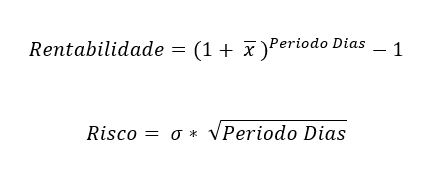


**Observação:** Estes cálculos de rentabilidade e risco são a respeito dos ativos. O cálculo da rentabilidade e do risco de uma carteira será explicado mais abaixo.


In [8]:
# Função para calcular a rentabilidade anualizada aplicada para retornos diários
def calcula_rentabilidade_ativo (dados, periodo_dias=252):
    
    # Media dos retornos
    media = dados.mean()
    
    rentabilidade = 1 + media
    
    # Anualizando os dados, periodo de dias se refere ao tempo passado por parametro
    rentabilidade = rentabilidade ** periodo_dias
    
    return rentabilidade - 1

In [9]:
# Função para calcular o risco anualizada aplicada para retornos diários
def calcula_risco_ativo (dados, periodo_dias=252):
    
    # Calculo do risco por desvio padrão
    desvio_padrao = dados.std()
    
    anualizar_periodo = np.sqrt(periodo_dias)
    
    # Novamente o periodo de dias serve para deixar o periodo anualizado, mensal, semanal ...
    risco = desvio_padrao * anualizar_periodo
    
    return risco

**Cálculo da Rentabilidade/Risco da Carteira de Ativos**

Acima temos as fórmulas de como calcular a rentabilidade e o risco anualizado (normalizado/padronizado) de um único ativo. Acontece que, para as carteiras, é preciso ter alguns detalhes extras, principalmente quando se calcula o risco.

Para calcular a rentabilidade de uma carteira é simples: toda carteira tem um peso, ou a ponderação dos ativos. Logo, para calcular a rentabilidade da carteira, basta calcular a rentabilidade do ativo e ponderar, ou seja, calcular a rentabilidade do ativo e depois multiplicar a rentabilidade com o peso ou a representação deste ativo na carteira. Por exemplo, uma carteira tem o Ativo A com 40% de representação e rentabilidade de 9,60%, e o Ativo B com 60% de representação e rentabilidade de 6,00%. Logo, tirando a média ponderada, temos (9,60% * 40%) + (6,00% * 60%) = 7,44% de rentabilidade da carteira.

Já para calcular o risco, exige um pouco mais de detalhes. Claro, o risco também envolve a ponderação dos ativos — afinal, cada carteira tem uma representação —, mas também envolve correlação (outros também aplicam covariância) entre os ativos. É preciso verificar o quão "ligados" estão os ativos. Veja: um ativo com correlação negativa pode anular ou corrigir o movimento de outro ativo, mas um que tem correlação positiva pode ampliar ainda mais o risco. Abaixo, **a segunda fórmula é a forma matricial**, ou seja, a fórmula original. Logo, a primeira fórmula surgiu da segunda. Logo abaixo, nas funções, vamos colocar a forma matricial de calcular o risco da carteira.

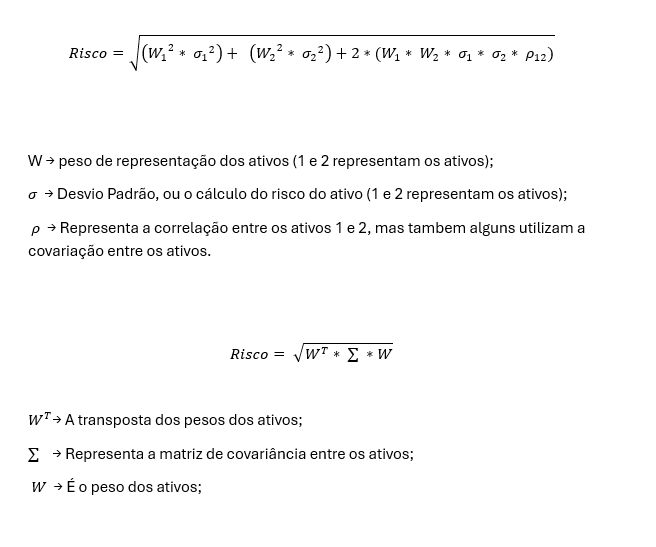


**Observações**  
No vídeo que referenciamos, há uma tabela Excel que mostra esta teoria. No cálculo do risco, há a covariância, e é por esse motivo que vamos utilizá-la para justamente confrontar os valores de primeiro momento e verificar se está dando certo.  

Um outro ponto é que, como estamos normalizando/padronizando os ativos de forma anual (252 dias), é preciso também normalizar a covariância, ou seja, multiplicar por 252.


In [10]:
def calcula_rentabilidade_carteira (df_percentual, df_participacao=None, coluna_peso=None, peso = None, periodo_dias = 252, percent=False):

    # Calculando as rentabilidades e o risco de cada ativo no periodo
    df_calculos = pd.DataFrame(index=[df_percentual.columns])

    # Periodo anualizado descontado finais de semanas, feriados e dias sem operações, em media é 252 dias
    periodo_dias = periodo_dias
    
    # passando por cada coluna de ativo
    for ativo in df_percentual.columns:

        # Deixando a leitura de variaveis mais fácil
        dados = df_percentual[ativo]
        rentabilidade = calcula_rentabilidade_ativo(dados, periodo_dias)
        risco = calcula_risco_ativo (dados, periodo_dias)

        # Inserindo as informações no novo dataframe de calculo
        df_calculos.at[ativo, 'Media'] = rentabilidade
        df_calculos.at[ativo, 'Desvio_Padrao'] = risco
    
    # Toda esta condição é caso a pessoa decida passar uma lista de peso
    # Ou entao no caso de ter um dataframe, passar e verificar a ordem dos ativos
    if peso is not None:
        # Colocando os pesos de participação no ibov
        df_calculos['Peso'] = peso.tolist()
        df_calculos['Peso'] = df_calculos['Peso'].astype(float)

    if (df_participacao is not None) and (coluna_peso is not None):
        # Resetando o índice de df_calculos para realizar o merge corretamente
        df_calculos = df_calculos.reset_index()
        
        # Realizando o merge com base no código
        df_calculos = df_calculos.merge(df_participacao[['Ativo', coluna_peso]], on='Ativo', how='left')

        # Renomeando a coluna para 'Peso'
        df_calculos = df_calculos.rename(columns={coluna_peso: 'Peso'})

        
    # Calculando as rentabilidades e o risco de cada ativo no periodo
    new_df_calculos = pd.DataFrame(index=[df_percentual.columns])
    
    if (percent == True):
        df_calculos['Peso'] = df_calculos['Peso'] / 100
    

    for col in df_calculos.columns:
        if col != 'Ativo':
            new_df_calculos[col] = df_calculos[col].tolist()
            new_df_calculos[col] = new_df_calculos[col].astype(float)
    

    # Calculando o retorno ponderado com a media e o peso do IBOV
    new_df_calculos['Retorno_Ponderado'] = new_df_calculos['Media'] * new_df_calculos['Peso']
    
    
    # Arredondando os valores
    new_df_calculos = new_df_calculos.round(6)
    
    
    # Calculo da rentabilidade
    rentabilidade = new_df_calculos['Retorno_Ponderado'].sum()
    
    return new_df_calculos, rentabilidade

In [11]:
def calcula_risco_carteira(df_calculos, retornos_historicos, mostrar_print=False, periodo_dias = 252):
    # Obtenha os pesos dos ativos da carteira
    pesos = df_calculos['Peso'].values
    
    # Calculando a matriz de covariância dos retornos históricos, a matriz tambem deve ser anualizada
    matriz_cov = retornos_historicos.cov() * periodo_dias

    # Verifique se há valores NaN na matriz de covariância
    if matriz_cov.isnull().any().any():
        print("Erro: A matriz de covariância contém valores NaN.")
        return None, None

    # Cálculo da variância da carteira usando a matriz de covariância e os pesos
    risco_variancia = np.dot(pesos.T, np.dot(matriz_cov.values, pesos))

    # Cálculo do risco (volatilidade) da carteira
    risco_total = np.sqrt(risco_variancia)

    # Adiciona o risco individual de cada ativo
    df_calculos['Contribuicao_Risco_Carteira'] = df_calculos['Peso'] * risco_total

    return df_calculos, risco_total

In [12]:
%%time
# Calculando os retornos
df_calculos, rentabilidade = calcula_rentabilidade_carteira (df_percentual_ativos.drop(columns='Date'), df_participacao=df_participacao, 
                                                             coluna_peso='Peso Participacao', percent=True)

# Calculando os riscos
df_calculos, risco = calcula_risco_carteira (df_calculos, df_percentual_ativos.drop(columns='Date'), mostrar_print=True)

CPU times: total: 15.6 ms
Wall time: 15 ms


In [13]:
# Visualizando os calculos feitos
display(df_calculos)


print(f'Total do Retorno Ponderado Anualizado na Carteira do IBOV: {rentabilidade.round(4) * 100}%')
print(f'Total do Risco Ponderado Anualizado na Carteira do IBOV: {risco.round(4) * 100}%')

,Media,Desvio_Padrao,Peso,Retorno_Ponderado,Contribuicao_Risco_Carteira
Ativo,,,,,
ABEV3,-0.046568,0.274541,0.02841,-0.001323,0.006280
B3SA3,0.202944,0.647210,0.03135,0.006362,0.006930
BBAS3,-0.002738,0.416189,0.03837,-0.000105,0.008481
BBDC3,0.016134,0.345001,0.00794,0.000128,0.001755
BBDC4,0.078125,0.403875,0.03064,0.002394,0.006773
BEEF3,0.121956,0.423233,0.00079,0.000096,0.000175
BRAP4,0.031978,0.428583,0.00215,0.000069,0.000475
BRFS3,0.064929,0.408036,0.00768,0.000499,0.001698
BRKM5,0.098679,0.478068,0.00140,0.000138,0.000309


Total do Retorno Ponderado Anualizado na Carteira do IBOV: 2.02%
Total do Risco Ponderado Anualizado na Carteira do IBOV: 22.1%


In [14]:
# Passando a rentabilidade e o risco da carteira do IBOV
rentabilidade_ibov, risco_ibov = rentabilidade, risco

# 3. Comparando as Cotações

Nesta seção, vamos criar um *dataframe* que será utilizado para comparar a evolução dos percentuais. A primeira comparação que faremos será entre o IBOV, de 2008 até 2024, e o IBOV ponderado pelos ativos.  

Lembrando que, no segundo notebook, verificamos que havia uma diferença entre eles — afinal, o IBOV é constantemente ajustado. No entanto, a correlação entre esses dois métodos de cálculo era muito forte (lembrando que correlação não implica causalidade), o que indica que pode haver diferenças entre eles, mas talvez não tão significativas em termos de evolução.

E, claro, mais adiante, ao escolher uma carteira e tentar otimizá-la por outros métodos, também faremos uma comparação entre a carteira escolhida, a carteira melhorada e a composição do próprio IBOV.

In [15]:
# criar um dataframe com ponderação dos percentuais
ativos_ponderados = pd.DataFrame(columns=df_percentual_ativos.drop(columns='Date').columns) 

# Só é possivel devido a ordem dos ativos
for ativo in ativos_ponderados.columns:
    # Peso em decimal
    peso = df_participacao[df_participacao['Ativo'] == ativo]['Peso Participacao'] / 100
    peso = peso.iloc[0]
    # Multiplica o percentual de variação de abertura dos ativos
    ativos_ponderados[ativo] = df_percentual_ativos.drop(columns='Date')[ativo] * peso
    
# Visualizando as alterações
display(ativos_ponderados)

Ativo,ABEV3,B3SA3,BBAS3,BBDC3,BBDC4,BEEF3,BRAP4,BRFS3,BRKM5,CCRO3,CMIG4,CPFE3,CPLE6,CSAN3,CSNA3,CYRE3,EGIE3,ELET3,ELET6,EMBR3,ENEV3,EQTL3,GGBR4,GOAU4,HYPE3,ISAE4,ITSA4,ITUB4,JBSS3,LREN3,MRFG3,MRVE3,MULT3,PCAR3,PETR3,PETR4,POMO4,PSSA3,RADL3,RENT3,SBSP3,SLCE3,SMTO3,SUZB3,TAEE11,TIMS3,TOTS3,UGPA3,USIM5,VALE3,VIVT3,WEGE3,YDUQ3
0,0.000409,0.000897,0.000802,0.000572,0.000000,0.000026,0.000000,0.000336,0.000030,-0.000107,0.000000,0.000041,0.000077,-0.000026,0.000054,0.000064,0.000183,0.001043,0.000000,0.000056,0.000244,0.000000,0.000000,0.000102,0.000000,0.000264,0.003811,0.003638,0.000183,0.000079,0.000003,-0.000010,0.000115,0.000000,0.000300,0.001269,0.000018,0.000154,0.001208,0.000934,-0.000387,1.159100e-05,-0.000003,0.000000,0.000288,0.000000,-0.000120,0.000000,0.000000,0.002818,0.000430,0.000310,0.000000
1,-0.000102,0.000335,0.000591,0.000087,0.000631,-0.000028,0.000072,-0.000035,0.000011,0.000142,0.000049,-0.000025,-0.000224,-0.000066,-0.000069,0.000029,0.000062,0.000340,0.000062,-0.000453,0.000072,0.000000,0.000000,-0.000065,0.000000,0.000000,0.000368,0.001482,0.000372,0.000081,-0.000003,0.000003,-0.000227,0.000000,0.000639,0.001293,0.000000,0.000083,-0.000170,-0.000612,-0.000905,1.176400e-05,0.000003,0.000000,-0.000252,0.000000,-0.000030,0.000000,0.000010,-0.000591,0.000043,0.000000,0.000000
2,0.000415,0.002793,0.000449,-0.000155,0.000377,0.000009,0.000090,0.000280,0.000060,0.000246,0.000203,0.000120,0.000391,0.000013,0.000110,0.000066,0.000000,0.000402,0.000037,0.000120,0.000223,0.000000,0.000000,0.000073,0.000000,0.000000,0.000093,-0.000571,0.000250,0.000099,0.000000,0.000026,0.000075,0.000000,0.002782,0.004076,-0.000018,0.000045,0.000173,0.000771,0.000651,-3.442700e-05,-0.000011,0.000000,-0.000030,0.000218,0.000214,0.000000,0.000043,0.004337,0.000274,0.000105,0.000000
3,0.000636,0.001712,-0.000879,-0.000085,-0.000570,0.000000,0.000020,-0.000237,-0.000019,-0.000128,-0.000050,0.000005,0.000000,-0.000235,0.000113,0.000000,-0.000296,-0.000483,-0.000098,0.000109,-0.000110,0.000000,0.000000,0.000077,0.000000,0.000000,0.000000,0.000000,0.000063,0.000383,0.000019,0.000033,0.000150,0.000000,0.001574,0.002428,0.000074,0.000046,0.000356,0.000623,0.000350,1.159100e-05,-0.000067,0.000000,0.000015,0.000014,0.000417,0.000000,0.000071,0.002133,-0.000015,-0.000102,0.000000
4,-0.000418,-0.001273,-0.000790,-0.000167,-0.000447,-0.000005,0.000000,-0.000017,-0.000002,-0.000186,0.000000,-0.000005,-0.000078,-0.000189,-0.000062,-0.000173,0.000088,-0.000027,-0.000012,-0.000053,0.000000,0.000000,0.000000,0.000019,0.000000,0.000000,-0.000273,-0.000729,0.000517,0.000254,-0.000008,-0.000006,-0.000042,0.000000,-0.002500,-0.004123,-0.000054,0.000071,0.000366,0.000458,-0.000077,0.000000e+00,-0.000091,0.000000,0.000000,0.000000,0.000130,0.000000,0.000000,-0.002284,-0.000007,0.000747,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4205,0.001267,-0.000865,-0.000303,-0.000178,-0.000659,-0.000001,0.000000,-0.000023,0.000046,-0.000096,-0.000196,-0.000053,-0.000080,-0.000110,-0.000018,-0.000068,-0.000063,-0.000440,-0.000098,0.000426,-0.000127,-0.000159,0.000061,-0.000015,-0.000153,-0.000066,-0.000413,-0.000888,0.000505,-0.000193,-0.000067,-0.000005,-0.000103,-0.000017,0.000322,0.000662,0.000051,0.000041,-0.000031,-0.000524,0.000220,8.650000e-07,-0.000031,0.000289,-0.000062,-0.000060,-0.000019,-0.000141,0.000023,-0.001809,-0.000090,0.000445,-0.000071
4206,0.000023,0.000031,0.000257,0.000126,0.000558,0.000015,0.000015,0.000094,0.000045,0.000147,0.000366,0.000131,0.000249,-0.000009,0.000164,0.000119,0.000159,0.000537,0.000092,-0.000245,0.000487,0.000815,0.000247,0.000116,-0.000110,0.000100,0.000355,0.001553,0.000183,0.000392,0.000022,0.000049,0.000125,-0.000006,-0.000331,-0.000024,0.000072,0.000037,0.000068,0.000378,-0.000671,4.636400e-05,0.000054,-0.000424,0.000112,0.000046,-0.000041,0.0001

In [16]:
# Criando um dataframe de carteiras
df_carteiras_ibov = pd.DataFrame()

# Passando a variação ponderada para este novo dataframe
df_carteiras_ibov['IBOV_Ponderado_1'] = ativos_ponderados.sum(axis=1)

# Visualizando o dataframe
display(df_carteiras_ibov)

,IBOV_Ponderado_1
0,0.020113
1,0.003015
2,0.019889
3,0.008060
4,-0.011449
...,...
4205,-0.003938
4206,0.007169
4207,0.001328
4208,0.005817


In [17]:
# Passando as alterações
df_carteiras_ibov['IBOV'] = df_ibov['Percentual']
df_carteiras_ibov['Date'] = df_ibov['Date']

# Reorganizando o dataframe de carteiras
df_carteiras_ibov = df_carteiras_ibov[['Date', 'IBOV', 'IBOV_Ponderado_1']]

# Convertendo a coluna 'Date' para datetime
df_carteiras_ibov['Date'] = pd.to_datetime(df_carteiras_ibov['Date'])

# Visualizando as alterações
display(df_carteiras_ibov)

,Date,IBOV,IBOV_Ponderado_1
0,2008-01-02,0.017050,0.020113
1,2008-01-03,-0.001224,0.003015
2,2008-01-04,0.030391,0.019889
3,2008-01-07,0.004361,0.008060
4,2008-01-08,-0.021085,-0.011449
...,...,...,...
4205,2024-12-20,-0.007486,-0.003938
4206,2024-12-23,0.011054,0.007169
4207,2024-12-26,-0.002569,0.001328
4208,2024-12-27,0.006727,0.005817


In [18]:
# Criando o grupo de Mes e Ano, para nao ficar um gráfico com muita volatilidade
df_carteiras_ibov['Ano'] = df_carteiras_ibov['Date'].dt.to_period('Y')

# Agrupar por 'Ano' e somar os percentuais da coluna 'Part. (%)'
df_carteira_agrupado = df_carteiras_ibov.groupby('Ano')[['IBOV', 'IBOV_Ponderado_1']].sum()*100

df_carteira_agrupado = df_carteira_agrupado.round(2)

# Visualizando o grupo
display(df_carteira_agrupado)

,IBOV,IBOV_Ponderado_1
Ano,,
2008,66.66,71.51
2009,-55.40,-35.58
2010,0.99,1.75
2011,23.03,18.50
2012,-4.84,-2.47
2013,18.90,6.92
2014,6.07,16.17
2015,16.92,23.11
2016,-29.39,-28.35


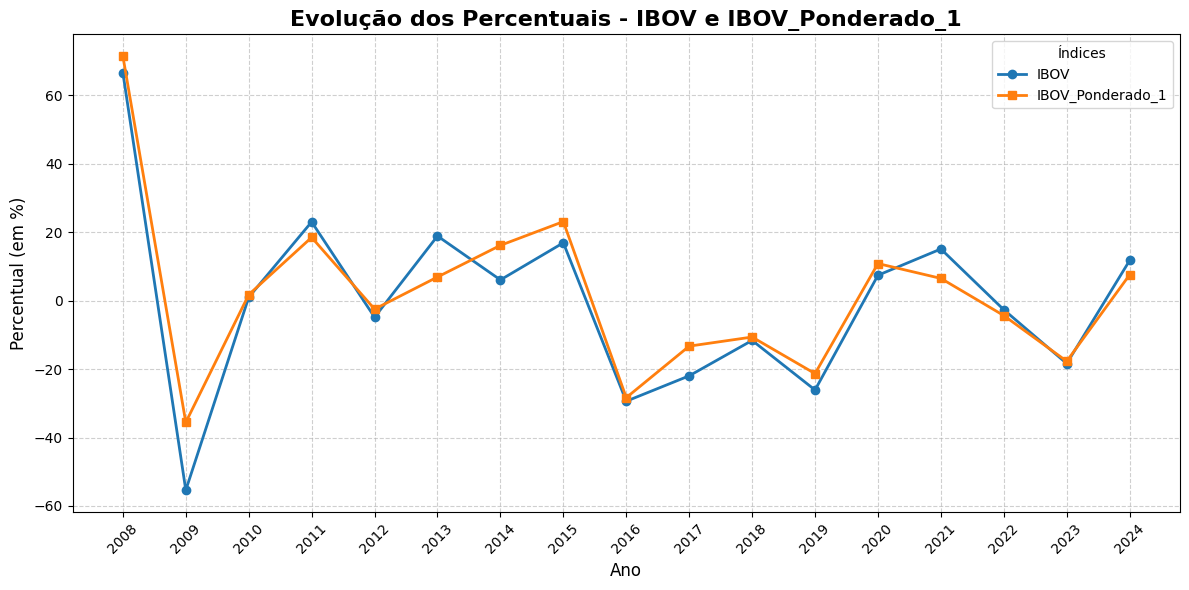

In [19]:
import matplotlib.pyplot as plt

# Reorganizando as carteiras novamente
df_carteiras_ibov = df_carteiras_ibov[['Date', 'Ano', 'IBOV', 'IBOV_Ponderado_1']]

# Criando o gráfico de linha para as colunas 'IBOV' e 'IBOV_1'
plt.figure(figsize=(12, 6))  # Tamanho do gráfico
plt.plot(df_carteira_agrupado.index.astype(str), df_carteira_agrupado['IBOV'], label='IBOV', marker='o', linestyle='-', color='#1f77b4', linewidth=2)
plt.plot(df_carteira_agrupado.index.astype(str), df_carteira_agrupado['IBOV_Ponderado_1'], label='IBOV_Ponderado_1', marker='s', linestyle='-', color='#ff7f0e', linewidth=2)

# Personalizando o gráfico
plt.title('Evolução dos Percentuais - IBOV e IBOV_Ponderado_1', fontsize=16, fontweight='bold')  # Título
plt.xlabel('Ano', fontsize=12)  # Rótulo do eixo X
plt.ylabel('Percentual (em %)', fontsize=12)  # Rótulo do eixo Y

# Rotacionando os rótulos do eixo X para facilitar a leitura
plt.xticks(rotation=45)

# Adicionando uma legenda
plt.legend(title='Índices', loc='upper right')

# Adicionando um grid para melhor visualização
plt.grid(True, linestyle='--', alpha=0.6)

# Exibindo o gráfico
plt.tight_layout()  # Ajusta o layout para não cortar partes do gráfico
plt.show()

**Comentários sobre o Gráfico**

É importante verificar que, no período de análise de 2008 a 2024, enfrentamos 3 crises econômicas. A primeira é a crise de 2008, que estourou em meados de setembro daquele ano. É por este motivo que podemos notar que houve uma rentabilidade média de 60% em 2008 e, depois, caiu para quase -60% em 2009. 

Outra crise foram as manifestações e os escândalos de corrupção, que tiveram o ápice em 2016, fazendo o mercado cair mais de 20%. Depois, houve uma recuperação.

Com respeito à crise da Covid-19, o ápice foi em 2020. Embora a queda tenha sido grande, no período anual também houve uma forte recuperação, atingindo patamares até maiores que os de antes da pandemia. No entanto, os efeitos podem ser vistos nos anos posteriores, de 2021 a 2023.

O que tambem podemos notar é como a ponderação dos ativos são bem correlacionados, é obvio que há uma diferença, algumas talvez significantes, mas a ponderação dos ativos estão respeitando bem a cotação do IBOV.

# 4. Fronteira Eficiente

**Desafio:** Será preciso testar valores para os pesos até chegar na melhor composição. No entanto, fazer isso de maneira bruta, ou seja, testando valor por valor, seria inviável, pois levaria muito tempo. Esse dilema é bem parecido com a busca de hiperparâmetros em modelos de machine learning. Se pararmos para pensar, a composição dos pesos é, de fato, um hiperparâmetro nessa teoria. Logo, existem duas abordagens para essa busca: a busca aleatória (*random search*), que tenta valores aleatórios e, com base na probabilidade, pode encontrar um bom parâmetro, e a busca bayesiana. Usando a referência do Mário Filho sobre [busca bayesiana](https://www.youtube.com/watch?v=WhnkeasZNHI), podemos utilizar a função `gp_minimize` para encontrar os melhores parâmetros (composição dos pesos) para calcular a rentabilidade e o risco da carteira.

**Ps:** A `gp_minimize` é eficaz para espaços grandes e não-lineares. O espaço que temos, com 79 parâmetros, é grande, mas como a soma desses parâmetros tem de ser igual a 1, ele é linear. No entanto, a otimização não ocorre completamente em cima dos pesos. Os pesos são utilizados para calcular a rentabilidade e o risco da carteira, o que torna o problema não-linear.

Para procurar a melhor medida, vamos usar o *Índice de Sharpe*, que utiliza a fórmula (rentabilidade - taxa livre / risco). Neste caso, a taxa livre é um percentual que queremos como alvo ou meta. Podemos utilizar a média da Selic ou a média da inflação.

Na pasta *data*, o arquivo `"Selic_Historico.xlsx"` contém a cotação histórica da Selic e da inflação. Neste caso, vamos usar a inflação. O próprio Tesouro Selic aplica como prêmio a inflação + ganho. Logo, a taxa livre será a **média da inflação no período de 2008 a 2024, que é 5,80%**.

In [20]:
# Verificando a composição do ibovespa
display(df_participacao)

,Ativo,Ano Fundacao,Ano IPO,Valor Mercado,Setor,Segmento,Idade,Tempo em Bolsa,Peso Participacao,EmpresaIPO,ClassEmpresa
0,VALE3,1943,1970,223954633000,Materiais Básicos,Minerais Metálicos,82,55,11.595,Consolidada,Large Caps
1,ITUB4,1943,2002,313335024000,Financeiro,Bancos,82,23,7.925,Consolidada,Large Caps
2,PETR4,1953,1977,426601191000,"Petróleo, Gás e Biocombustíveis","Exploração, Refino e Distribuição",72,48,7.884,Consolidada,Large Caps
3,PETR3,1953,1977,426601191000,"Petróleo, Gás e Biocombustíveis","Exploração, Refino e Distribuição",72,48,4.409,Consolidada,Large Caps
4,ELET3,1962,1971,98986984000,Utilidade Pública,Energia Elétrica,63,54,3.862,Consolidada,Mid Caps
...,...,...,...,...,...,...,...,...,...,...,...
82,PETZ3,2013,2020,1776090000,Consumo não Cíclico,Produtos Diversos,12,5,0.058,Recente,Small Caps
83,CVCB3,2009,2013,1035414000,Consumo Cíclico,Viagens e Turismo,16,12,0.053,Normal,Small Caps
84,AZUL4,2008,2017,986716000,Bens Industriais,Transporte Aéreo,17,8,0.051,Recente,Small Caps
85,LWSA3,1997,2020,1502906000,Tecnologia da Informação,Programas e Serviços,28,5,0.050,Recente,Small Caps


In [21]:
# Lista de ativos apenas de 2008
lista_ativos = df_percentual['Ativo'].unique().tolist()

print(f"Quantidade de Ativos: {len(lista_ativos)}")

Quantidade de Ativos: 53


In [22]:
# Filtrando os ativos só de 2008
df_comp_teste = df_participacao[df_participacao['Ativo'].isin(lista_ativos)].copy().reset_index(drop=True)


# Visualizando as alterações
display(df_comp_teste)

,Ativo,Ano Fundacao,Ano IPO,Valor Mercado,Setor,Segmento,Idade,Tempo em Bolsa,Peso Participacao,EmpresaIPO,ClassEmpresa
0,VALE3,1943,1970,223954633000,Materiais Básicos,Minerais Metálicos,82,55,11.595,Consolidada,Large Caps
1,ITUB4,1943,2002,313335024000,Financeiro,Bancos,82,23,7.925,Consolidada,Large Caps
2,PETR4,1953,1977,426601191000,"Petróleo, Gás e Biocombustíveis","Exploração, Refino e Distribuição",72,48,7.884,Consolidada,Large Caps
3,PETR3,1953,1977,426601191000,"Petróleo, Gás e Biocombustíveis","Exploração, Refino e Distribuição",72,48,4.409,Consolidada,Large Caps
4,ELET3,1962,1971,98986984000,Utilidade Pública,Energia Elétrica,63,54,3.862,Consolidada,Mid Caps
5,BBAS3,1808,1977,156394460000,Financeiro,Bancos,217,48,3.837,Consolidada,Large Caps
6,SBSP3,1973,1994,68897794000,Utilidade Pública,Água e Saneamento,52,31,3.338,Consolidada,Mid Caps
7,B3SA3,2007,2008,63490050000,Financeiro,Serviços Financeiros Diversos,18,17,3.135,Normal,Mid Caps
8,BBDC4,1943,1977,119553442000,Financeiro,Bancos,82,48,3.064,Consolidada,Large Caps
9,ABEV3,2005,2013,208473806000,Consumo não Cíclico,Cervejas e Refrigerantes,20,12,2.841,Normal,Large Caps


**Os pesos sorteados vão seguir esta ordem de `VALE3`, `ITUB4`, `PETR4`, `PETRA3` ... `RAIZ4`, `VAMO3`**

In [23]:
# Imports
from skopt import gp_minimize
from skopt.space import Real

In [24]:
# Algumas Configuracoes de arredondamento
arredondamento_pesos = 1
arredondamento_pesos_completos = 4

In [25]:
# Garantindo a semente de aleatoriedade
np.random.seed(42)

# Espaço com 53 ativos possíveis, todos com peso entre 0.01 e 1.0
dimensao = [Real(0.01, 2.0) for _ in range(53)]

In [26]:
# Criando um dataframe para analise
df_fronteira_eficiente = pd.DataFrame(columns=['Pesos_Sorteados', 'Rentabilidade', 'Risco', 'Retorno/Risco', 'Sharpe'])

def funcao_objetivo_retorno_risco(params):
    pesos = [round(p, arredondamento_pesos) for p in params]
    pesos_completos = pesos / np.sum(pesos)
    
    
    print(f'===================================> Soma dos Pesos: {pesos_completos.sum().round(arredondamento_pesos_completos)}')
    print(f'===================================> Pesos Ordenados: {np.sort(pesos_completos)[::-1].round(arredondamento_pesos_completos)}')
    
    # colocando os novos pesos sorteados
    df_comp_teste['Peso Participacao'] = pesos_completos
    df_comp_teste['Peso Participacao'] = df_comp_teste['Peso Participacao'].round(arredondamento_pesos_completos)
    
    # Criando o calculo da rentabilidade
    df_calculos, rentabilidade = calcula_rentabilidade_carteira (df_percentual_ativos.drop(columns='Date'), df_participacao = df_comp_teste, coluna_peso='Peso Participacao')
    
    # Calculando os riscos
    df_calculos, risco = calcula_risco_carteira (df_calculos, df_percentual_ativos.drop(columns='Date'))
    
    print(f' -------------------> Retorno Ponderado Anualizado na Carteira do IBOV: {rentabilidade.round(4) * 100}%')
    print(f' -------------------> Risco Ponderado Anualizado na Carteira do IBOV: {risco.round(4) * 100}%')
    
    # Calculo do retorno-risco
    sharpe = (rentabilidade - 0.058) / risco
    retorno_risco = rentabilidade / risco
    
    registro_peso = [', '.join(map(str, pesos_completos))] * len(df_comp_teste)

    # Criando o dicionário com as chaves e valores
    novo_registro = {'Pesos_Sorteados': registro_peso, 'Rentabilidade': rentabilidade, 
                     'Risco': risco, 'Retorno/Risco': retorno_risco, 'Sharpe': sharpe}
    
    # Transformando o registro em um DataFrame
    df_novo_registro = pd.DataFrame(novo_registro)
    
    # Definindo uma variavel global o dataframe
    global df_fronteira_eficiente
    
    # Criando uma nova linha no dataframe
    df_fronteira_eficiente = pd.concat([df_fronteira_eficiente, df_novo_registro], ignore_index=True)
    
    df_fronteira_eficiente = df_fronteira_eficiente.drop_duplicates()
    
    return -sharpe

In [27]:
%%time
# Executando a otimização
resultado = gp_minimize(funcao_objetivo_retorno_risco, dimensao, n_calls=150, n_random_starts=30, random_state=0, verbose=1)

Iteration No: 1 started. Evaluating function at random point.
===================================> Soma dos Pesos: 1.0
===================================> Pesos Ordenados: [0.0342 0.0342 0.0342 0.0324 0.0324 0.0306 0.0306 0.0306 0.0306 0.0306
 0.0288 0.0288 0.027  0.027  0.027  0.0252 0.0252 0.0234 0.0234 0.0234
 0.0234 0.0216 0.0216 0.0216 0.0216 0.0198 0.018  0.018  0.018  0.018
 0.018  0.0162 0.0144 0.0144 0.0144 0.0126 0.0126 0.0126 0.0126 0.0126
 0.0108 0.0108 0.009  0.0072 0.0072 0.0072 0.0054 0.0054 0.0054 0.0036
 0.0036 0.0018 0.0018]
 -------------------> Retorno Ponderado Anualizado na Carteira do IBOV: 2.2399999999999998%
 -------------------> Risco Ponderado Anualizado na Carteira do IBOV: 23.02%
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0166
Function value obtained: 0.1545
Current minimum: 0.1545
Iteration No: 2 started. Evaluating function at random point.
===================================> Soma dos Pesos: 1.0
===============================

 -------------------> Retorno Ponderado Anualizado na Carteira do IBOV: 3.44%
 -------------------> Risco Ponderado Anualizado na Carteira do IBOV: 24.01%
Iteration No: 14 ended. Evaluation done at random point.
Time taken: 0.0150
Function value obtained: 0.0981
Current minimum: 0.0417
Iteration No: 15 started. Evaluating function at random point.
===================================> Soma dos Pesos: 1.0
===================================> Pesos Ordenados: [0.0336 0.0336 0.0336 0.0336 0.0319 0.0319 0.0303 0.0303 0.0303 0.0286
 0.0269 0.0269 0.0269 0.0252 0.0252 0.0252 0.0252 0.0235 0.0235 0.0235
 0.0235 0.0218 0.0218 0.0202 0.0202 0.0202 0.0202 0.0202 0.0185 0.0185
 0.0185 0.0168 0.0151 0.0151 0.0151 0.0134 0.0134 0.0134 0.0134 0.0118
 0.0118 0.0101 0.0101 0.0084 0.0084 0.0067 0.0067 0.005  0.0034 0.0034
 0.0017 0.0017 0.0017]
 -------------------> Retorno Ponderado Anualizado na Carteira do IBOV: 3.49%
 -------------------> Risco Ponderado Anualizado na Carteira do IBOV: 23.76%
Iterat

 -------------------> Retorno Ponderado Anualizado na Carteira do IBOV: 2.71%
 -------------------> Risco Ponderado Anualizado na Carteira do IBOV: 23.35%
Iteration No: 25 ended. Evaluation done at random point.
Time taken: 0.0176
Function value obtained: 0.1321
Current minimum: 0.0417
Iteration No: 26 started. Evaluating function at random point.
===================================> Soma dos Pesos: 1.0
===================================> Pesos Ordenados: [0.0349 0.0349 0.0349 0.0331 0.0312 0.0312 0.0294 0.0294 0.0294 0.0294
 0.0294 0.0294 0.0294 0.0276 0.0276 0.0276 0.0276 0.0257 0.0239 0.0239
 0.0239 0.0221 0.0221 0.0202 0.0202 0.0202 0.0202 0.0184 0.0184 0.0184
 0.0184 0.0184 0.0165 0.0165 0.0165 0.0165 0.0147 0.0147 0.0129 0.0092
 0.0092 0.0092 0.0074 0.0055 0.0037 0.0037 0.0037 0.0037 0.0037 0.0018
 0.     0.     0.    ]
 -------------------> Retorno Ponderado Anualizado na Carteira do IBOV: 4.15%
 -------------------> Risco Ponderado Anualizado na Carteira do IBOV: 24.3%
Iterati

Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 0.3677
Function value obtained: 0.0997
Current minimum: -0.0230
Iteration No: 36 started. Searching for the next optimal point.
===================================> Soma dos Pesos: 1.0
===================================> Pesos Ordenados: [0.0382 0.0382 0.0382 0.0382 0.0382 0.0382 0.0382 0.0382 0.0382 0.0382
 0.0382 0.0382 0.0382 0.0382 0.0382 0.0382 0.0363 0.0344 0.0344 0.0344
 0.0286 0.0286 0.0267 0.0229 0.021  0.021  0.0172 0.0172 0.0134 0.0134
 0.0115 0.0095 0.0095 0.0038 0.0019 0.0019 0.0019 0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.    ]
 -------------------> Retorno Ponderado Anualizado na Carteira do IBOV: 6.4%
 -------------------> Risco Ponderado Anualizado na Carteira do IBOV: 24.8%
Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 0.3513
Function value obtained: -0.0242
Current minimum: -0.0242
Iteration No:

Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 0.4429
Function value obtained: -0.0914
Current minimum: -0.0914
Iteration No: 46 started. Searching for the next optimal point.
===================================> Soma dos Pesos: 1.0
===================================> Pesos Ordenados: [0.0333 0.0333 0.0333 0.0333 0.0317 0.0317 0.0317 0.03   0.0283 0.0283
 0.0283 0.0283 0.0283 0.0267 0.0267 0.0267 0.0267 0.0267 0.0267 0.0267
 0.0267 0.025  0.0233 0.0233 0.0233 0.02   0.0183 0.0183 0.0183 0.0183
 0.0183 0.015  0.015  0.015  0.015  0.0133 0.0133 0.0117 0.0117 0.0083
 0.0083 0.0067 0.0067 0.0067 0.0067 0.005  0.005  0.005  0.0033 0.0033
 0.0017 0.0017 0.0017]
 -------------------> Retorno Ponderado Anualizado na Carteira do IBOV: 4.41%
 -------------------> Risco Ponderado Anualizado na Carteira do IBOV: 23.799999999999997%
Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 0.4207
Function value obtained: 0.0586
Current minimum

Iteration No: 55 ended. Search finished for the next optimal point.
Time taken: 0.6953
Function value obtained: 0.0617
Current minimum: -0.1639
Iteration No: 56 started. Searching for the next optimal point.
===================================> Soma dos Pesos: 1.0
===================================> Pesos Ordenados: [0.0412 0.0412 0.0412 0.0412 0.0412 0.0412 0.0412 0.0412 0.0412 0.0412
 0.0412 0.0412 0.0412 0.0412 0.0412 0.0412 0.0412 0.0412 0.0412 0.0412
 0.0412 0.0412 0.033  0.0206 0.0206 0.0103 0.0082 0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.    ]
 -------------------> Retorno Ponderado Anualizado na Carteira do IBOV: 9.91%
 -------------------> Risco Ponderado Anualizado na Carteira do IBOV: 26.76%
Iteration No: 56 ended. Search finished for the next optimal point.
Time taken: 0.6613
Function value obtained: -0.1537
Current minimum: -0.1639
Iteration No: 5

Iteration No: 65 ended. Search finished for the next optimal point.
Time taken: 0.9775
Function value obtained: -0.1869
Current minimum: -0.2182
Iteration No: 66 started. Searching for the next optimal point.
===================================> Soma dos Pesos: 1.0
===================================> Pesos Ordenados: [0.0456 0.0456 0.0456 0.0456 0.0456 0.0456 0.0456 0.0456 0.0456 0.0456
 0.0456 0.0387 0.0387 0.0364 0.0364 0.0342 0.0342 0.0296 0.0273 0.0251
 0.0251 0.0251 0.0228 0.0205 0.0159 0.0159 0.0137 0.0114 0.0114 0.0091
 0.0091 0.0068 0.0046 0.0046 0.0023 0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.    ]
 -------------------> Retorno Ponderado Anualizado na Carteira do IBOV: 8.6%
 -------------------> Risco Ponderado Anualizado na Carteira do IBOV: 25.240000000000002%
Iteration No: 66 ended. Search finished for the next optimal point.
Time taken: 0.9479
Function value obtained: -0.1109
Current minimum: -0.218

Iteration No: 75 ended. Search finished for the next optimal point.
Time taken: 2.4484
Function value obtained: -0.2112
Current minimum: -0.2763
Iteration No: 76 started. Searching for the next optimal point.
===================================> Soma dos Pesos: 1.0
===================================> Pesos Ordenados: [0.0503 0.0503 0.0503 0.0503 0.0503 0.0503 0.0503 0.0503 0.0503 0.0503
 0.0503 0.0477 0.0452 0.0402 0.0377 0.0352 0.0327 0.0302 0.0302 0.0251
 0.0226 0.0201 0.0201 0.0201 0.0126 0.0101 0.0075 0.005  0.005  0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.    ]
 -------------------> Retorno Ponderado Anualizado na Carteira do IBOV: 11.12%
 -------------------> Risco Ponderado Anualizado na Carteira do IBOV: 26.05%
Iteration No: 76 ended. Search finished for the next optimal point.
Time taken: 3.3003
Function value obtained: -0.2041
Current minimum: -0.2763
Iteration No:

Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 3.7970
Function value obtained: -0.2421
Current minimum: -0.2939
Iteration No: 86 started. Searching for the next optimal point.
===================================> Soma dos Pesos: 1.0
===================================> Pesos Ordenados: [0.0612 0.0612 0.0612 0.0612 0.0612 0.0612 0.0612 0.0612 0.0612 0.0612
 0.0612 0.0612 0.0612 0.0612 0.0489 0.0459 0.0367 0.0092 0.0031 0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.    ]
 -------------------> Retorno Ponderado Anualizado na Carteira do IBOV: 12.7%
 -------------------> Risco Ponderado Anualizado na Carteira do IBOV: 27.279999999999998%
Iteration No: 86 ended. Search finished for the next optimal point.
Time taken: 3.7347
Function value obtained: -0.2530
Current minimum: -0.2939
Itera

Iteration No: 95 ended. Search finished for the next optimal point.
Time taken: 3.6107
Function value obtained: -0.2848
Current minimum: -0.3476
Iteration No: 96 started. Searching for the next optimal point.
===================================> Soma dos Pesos: 1.0
===================================> Pesos Ordenados: [0.0787 0.0787 0.0787 0.0787 0.0787 0.0787 0.0787 0.0787 0.0787 0.0787
 0.0787 0.063  0.0315 0.0276 0.0118 0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.    ]
 -------------------> Retorno Ponderado Anualizado na Carteira do IBOV: 15.83%
 -------------------> Risco Ponderado Anualizado na Carteira do IBOV: 29.45%
Iteration No: 96 ended. Search finished for the next optimal point.
Time taken: 3.1153
Function value obtained: -0.3404
Current minimum: -0.3476
Iteration No: 97 

Iteration No: 105 ended. Search finished for the next optimal point.
Time taken: 3.6049
Function value obtained: -0.2988
Current minimum: -0.3573
Iteration No: 106 started. Searching for the next optimal point.
===================================> Soma dos Pesos: 1.0
===================================> Pesos Ordenados: [0.083  0.083  0.083  0.083  0.083  0.083  0.083  0.083  0.083  0.0705
 0.0581 0.0332 0.029  0.0249 0.0166 0.0166 0.0041 0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.    ]
 -------------------> Retorno Ponderado Anualizado na Carteira do IBOV: 14.02%
 -------------------> Risco Ponderado Anualizado na Carteira do IBOV: 27.08%
Iteration No: 106 ended. Search finished for the next optimal point.
Time taken: 4.4068
Function value obtained: -0.3037
Current minimum: -0.3573
Iteration No: 

Iteration No: 115 ended. Search finished for the next optimal point.
Time taken: 11.5523
Function value obtained: -0.3547
Current minimum: -0.4370
Iteration No: 116 started. Searching for the next optimal point.
===================================> Soma dos Pesos: 1.0
===================================> Pesos Ordenados: [0.0862 0.0862 0.0862 0.0862 0.0862 0.0862 0.0862 0.0862 0.0862 0.0819
 0.0517 0.0388 0.0345 0.0129 0.0043 0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.    ]
 -------------------> Retorno Ponderado Anualizado na Carteira do IBOV: 15.2%
 -------------------> Risco Ponderado Anualizado na Carteira do IBOV: 29.17%
Iteration No: 116 ended. Search finished for the next optimal point.
Time taken: 14.4462
Function value obtained: -0.3220
Current minimum: -0.4370
Iteration No:

Iteration No: 125 ended. Search finished for the next optimal point.
Time taken: 10.7475
Function value obtained: -0.4634
Current minimum: -0.4634
Iteration No: 126 started. Searching for the next optimal point.
===================================> Soma dos Pesos: 1.0
===================================> Pesos Ordenados: [0.0749 0.0749 0.0749 0.0749 0.0674 0.0637 0.0562 0.0562 0.0562 0.0449
 0.0449 0.0412 0.0375 0.0337 0.0337 0.0262 0.0262 0.0225 0.0225 0.0187
 0.015  0.0112 0.0075 0.0075 0.0037 0.0037 0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.    ]
 -------------------> Retorno Ponderado Anualizado na Carteira do IBOV: 11.28%
 -------------------> Risco Ponderado Anualizado na Carteira do IBOV: 25.3%
Iteration No: 126 ended. Search finished for the next optimal point.
Time taken: 9.3039
Function value obtained: -0.2164
Current minimum: -0.4634
Iteration 

Iteration No: 135 ended. Search finished for the next optimal point.
Time taken: 16.1585
Function value obtained: -0.2643
Current minimum: -0.4757
Iteration No: 136 started. Searching for the next optimal point.
===================================> Soma dos Pesos: 1.0
===================================> Pesos Ordenados: [0.0656 0.0656 0.0656 0.0656 0.0656 0.0656 0.0656 0.0656 0.0623 0.059
 0.0525 0.0492 0.0426 0.0393 0.0361 0.0262 0.0262 0.0197 0.0197 0.0197
 0.0131 0.0098 0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.    ]
 -------------------> Retorno Ponderado Anualizado na Carteira do IBOV: 10.190000000000001%
 -------------------> Risco Ponderado Anualizado na Carteira do IBOV: 26.090000000000003%
Iteration No: 136 ended. Search finished for the next optimal point.
Time taken: 16.9873
Function value obtained: -0.1683
Current 

Iteration No: 145 ended. Search finished for the next optimal point.
Time taken: 18.3361
Function value obtained: -0.2301
Current minimum: -0.4757
Iteration No: 146 started. Searching for the next optimal point.
===================================> Soma dos Pesos: 1.0
===================================> Pesos Ordenados: [0.155  0.155  0.155  0.093  0.0853 0.0775 0.0698 0.0388 0.0388 0.031
 0.031  0.031  0.031  0.0078 0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.    ]
 -------------------> Retorno Ponderado Anualizado na Carteira do IBOV: 17.78%
 -------------------> Risco Ponderado Anualizado na Carteira do IBOV: 30.06%
Iteration No: 146 ended. Search finished for the next optimal point.
Time taken: 16.3996
Function value obtained: -0.3985
Current minimum: -0.4757
Iteration No:

In [28]:
# Pegando a melhor composição dos pesos
pesos = [round(p, arredondamento_pesos) for p in resultado.x]
pesos_completos = pesos / np.sum(pesos)

print(pesos_completos)

[0.         0.         0.         0.         0.02542373 0.
 0.         0.16949153 0.02542373 0.         0.         0.
 0.         0.         0.08474576 0.         0.         0.
 0.16949153 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.16949153
 0.         0.         0.         0.         0.         0.04237288
 0.16949153 0.         0.         0.05084746 0.09322034]


In [29]:
# Passando a composição de melhor indice sharpe
df_comp = df_comp_teste.copy()

# Colocando os pesos nos ativos
df_comp['Peso Participacao'] = pesos_completos.round(arredondamento_pesos_completos)

# Filtrando apenas ativos com peso
df_comp = df_comp[df_comp['Peso Participacao'] != 0]

# Organizando os dados por maior peso
df_comp = df_comp.sort_values(by='Peso Participacao', ascending=False)

# Resetando os indices
df_comp = df_comp.reset_index(drop=True)

print(f"Soma dos Pesos: {df_comp['Peso Participacao'].sum()}")

# Visualizando as alterações
display(df_comp)

Soma dos Pesos: 0.9999


,Ativo,Ano Fundacao,Ano IPO,Valor Mercado,Setor,Segmento,Idade,Tempo em Bolsa,Peso Participacao,EmpresaIPO,ClassEmpresa
0,B3SA3,2007,2008,63490050000,Financeiro,Serviços Financeiros Diversos,18,17,0.1695,Normal,Mid Caps
1,ENEV3,2001,2007,18762819000,Utilidade Pública,Energia Elétrica,24,18,0.1695,Normal,Mid Caps
2,GOAU4,1901,1968,7906282000,Materiais Básicos,Siderurgia,124,57,0.1695,Consolidada,Small Caps
3,USIM5,1954,1994,7984035000,Materiais Básicos,Siderurgia,71,31,0.1695,Consolidada,Small Caps
4,PCAR3,1981,1995,1490138000,Consumo não Cíclico,Alimentos,44,30,0.0932,Consolidada,Small Caps
5,EQTL3,1999,2006,40450120000,Utilidade Pública,Energia Elétrica,26,19,0.0847,Normal,Mid Caps
6,BEEF3,1992,2007,3795521000,Consumo não Cíclico,Carnes e Derivados,33,18,0.0508,Normal,Small Caps
7,BRKM5,1972,1978,6931882000,Materiais Básicos,Petroquímicos,53,47,0.0424,Consolidada,Small Caps
8,ELET3,1962,1971,98986984000,Utilidade Pública,Energia Elétrica,63,54,0.0254,Consolidada,Mid Caps
9,BBDC4,1943,1977,119553442000,Financeiro,Bancos,82,48,0.0254,Consolidada,Large Caps


In [30]:
# Criando o calculo da rentabilidade
df_calculos, rentabilidade_markowitz = calcula_rentabilidade_carteira (df_percentual_ativos[df_comp['Ativo'].tolist()], df_participacao = df_comp, coluna_peso='Peso Participacao')
    
# Calculando os riscos
df_calculos, risco_markowitz = calcula_risco_carteira (df_calculos,df_percentual_ativos[df_comp['Ativo'].tolist()])
    
print(f' -------------------> Retorno Ponderado Anualizado na Carteira do IBOV: {rentabilidade_markowitz.round(4) * 100}%')
print(f' -------------------> Risco Ponderado Anualizado na Carteira do IBOV: {risco_markowitz.round(4) * 100}%')

 -------------------> Retorno Ponderado Anualizado na Carteira do IBOV: 20.82%
 -------------------> Risco Ponderado Anualizado na Carteira do IBOV: 31.580000000000002%


In [31]:
# Salvando esta composição da carteira
df_comp.to_csv('data/Composicao_IBOV_Markowitz.csv', encoding='ISO-8859-1')

df_carteiras_ibov.to_csv('data/Carteiras_IBOV.csv', encoding='ISO-8859-1')

**Comentários**

Inicialmente, havia 53 ativos. Com a aplicação da busca bayesiana, foi possível reduzir significativamente esse número. Cabe lembrar que a busca tinha como objetivo maximizar o Índice de Sharpe, considerando como taxa livre de risco a média da inflação no período de 2008 a 2024 foi de 5,80%.

Assim, foram definidos os melhores parâmetros para os pesos e para a quantidade ideal de ativos. Na configuração original da carteira, a rentabilidade era de 2,02% e o risco de 22,10%. Já na nova configuração, apresentada no *dataframe* acima, a rentabilidade aumentou para 20,82%, mas também houve um acréscimo no risco, que passou para 31,58%. Isso indica que a nova composição apresenta resultados superiores em termos de retorno, porém com maior volatilidade. É importante destacar que tais dados representam evidências com base no histórico e não garantem previsões futuras. Há indícios de que essa nova alocação é mais rentável, mas também mais volátil em comparação à composição atual do IBOV.


**Antes de analisar a carteira com a melhor performance, vamos verificar como foi a busca e formalizar a fronteira de eficiencia.**

In [32]:
# Dataframe das fronteiras de eficiencia
df_fronteira_eficiente.sort_values(by='Sharpe', ascending=False).round(4)

,Pesos_Sorteados,Rentabilidade,Risco,Retorno/Risco,Sharpe
126,"0.0, 0.0, 0.0, 0.0, 0.025423728813559324, 0.0,...",0.2082,0.3158,0.6594,0.4757
147,"0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.139860139...",0.2025,0.3101,0.6531,0.4661
124,"0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.143884892...",0.2034,0.3138,0.6483,0.4634
113,"0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.117647058...",0.1908,0.3039,0.6278,0.4370
123,"0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.105820105...",0.1908,0.3106,0.6144,0.4276
...,...,...,...,...,...
27,"0.0264765784114053, 0.0264765784114053, 0.0386...",0.0184,0.2321,0.0792,-0.1707
10,"0.016216216216216217, 0.032432432432432434, 0....",0.0189,0.2225,0.0850,-0.1757
26,"0.034816247582205036, 0.005802707930367505, 0....",0.0169,0.2276,0.0743,-0.1806
15,"0.0, 0.039583333333333325, 0.02916666666666666...",0.0155,0.2225,0.0698,-0.1909


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


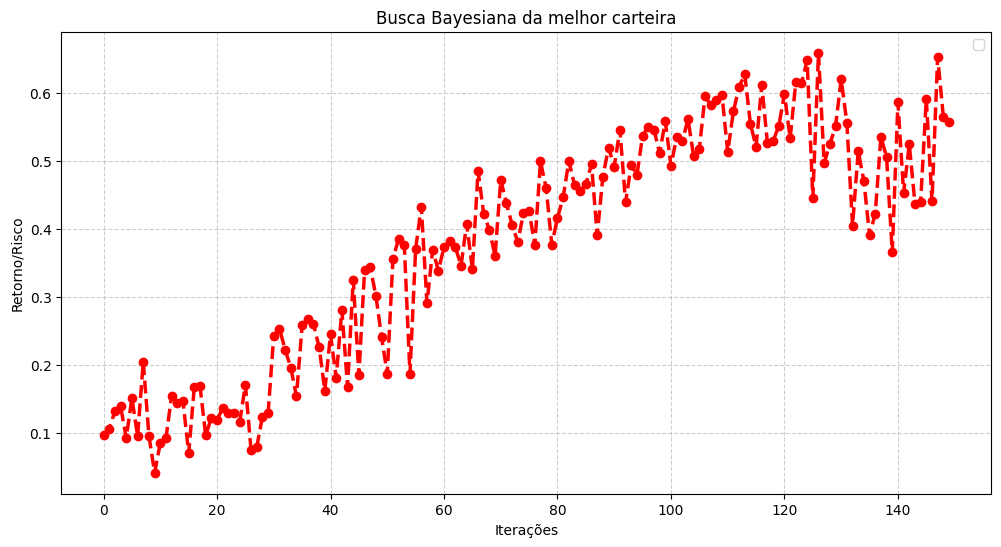

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Criando o gráfico de linha
plt.figure(figsize=(12, 6))
plt.plot(df_fronteira_eficiente.index, df_fronteira_eficiente["Retorno/Risco"], linestyle='--', marker='o', color='red', linewidth=2.5)

plt.title("Busca Bayesiana da melhor carteira")
plt.xlabel("Iterações")
plt.ylabel("Retorno/Risco")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

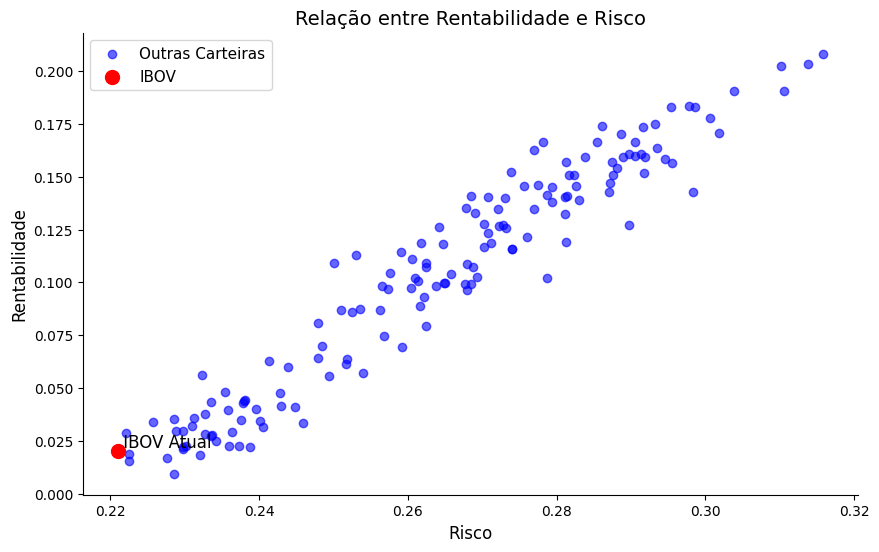

In [34]:
# Pegando os dados do DataFrame
x_risco = df_fronteira_eficiente["Risco"].values  # Eixo X (Risco)
y_retorno = df_fronteira_eficiente["Rentabilidade"].values  # Eixo Y (Retorno)

plt.figure(figsize=(10, 6))

# Scatter das carteiras
plt.scatter(x_risco, y_retorno, color="blue", label="Outras Carteiras", alpha=0.6)


# Adicionando ponto de destaque (IBOV)
destaque_x = risco_ibov
destaque_y = rentabilidade_ibov
plt.scatter(destaque_x, destaque_y, color='red', s=100, zorder=3, label="IBOV")
plt.text(destaque_x, destaque_y, " IBOV Atual", fontsize=12, verticalalignment='bottom', horizontalalignment='left', color='black')

# Títulos, eixos e legenda
plt.title("Relação entre Rentabilidade e Risco", fontsize=14)
plt.xlabel("Risco", fontsize=12)
plt.ylabel("Rentabilidade", fontsize=12)

# Plotando a legenda
plt.legend(fontsize=11)

# Removendo bordas superior e direita
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.show()


**Comentários**

Em relação à busca bayesiana, observa-se uma evolução à medida que as interações avançam. Uma questão que pode surgir é: por que o parâmetro `n_random_starts` foi definido como 30? O gráfico abaixo apresenta a busca pela melhor carteira. Percebe-se que, ao definir um valor muito alto para esse parâmetro, ocorre de fato uma evolução na otimização; no entanto, há um *gap* (espaço) entre as carteiras, o que acaba deformando o gráfico da relação entre rentabilidade e risco. Isso faz com que o comportamento da curva se distancie do esperado pela teoria da fronteira eficiente de Markowitz. Portanto, utilizar valores mais baixos para esse parâmetro tende a gerar uma evolução mais linear e suave entre as carteiras.

Ao observar o gráfico da **Relação entre Rentabilidade e Risco**, nota-se que o comportamento se assemelha mais a uma linha reta do que a uma curva. Assim, não há uma representação clara da fronteira eficiente. Esse comportamento pode estar relacionado ao número de possibilidades geradas, dado que foram considerados 53 ativos e apenas 150 interações. Esse número de interações pode ser insuficiente para cobrir adequadamente o espaço de busca e, como a busca bayesiana tende a refinar as melhores soluções, o resultado acaba assumindo uma forma mais linear.

Espera-se que, ao reduzir a quantidade de ativos, o número de possibilidades também diminua, aumentando assim a chance de formar uma curva mais característica da fronteira eficiente.

Nos gráficos a seguir, apresentam-se os resultados de uma busca onde o parâmetro `n_random_starts` foi definido como 120 (correspondendo a 80% das interações), com o objetivo de comparar com os gráficos anteriores e ilustrar o problema de se utilizar valores elevados para esse parâmetro.

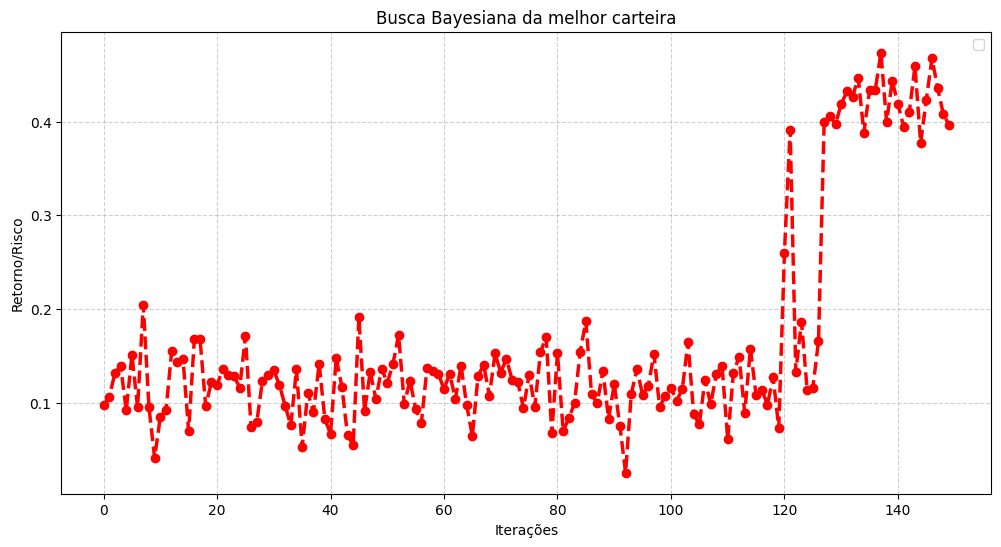

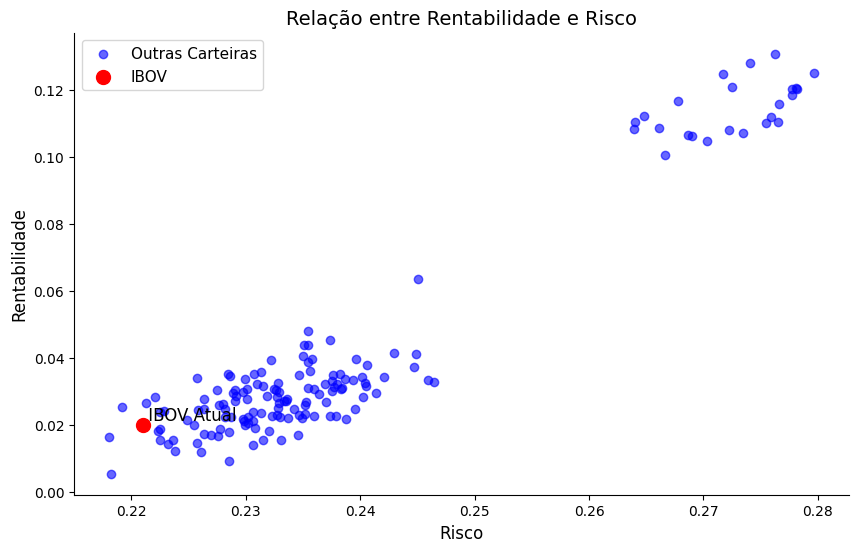


### 4.1.1. Avaliando a performance da carteira escolhida

In [35]:
# Olhando os percentuais
display(df_percentual_ativos)

Ativo,Date,ABEV3,B3SA3,BBAS3,BBDC3,BBDC4,BEEF3,BRAP4,BRFS3,BRKM5,CCRO3,CMIG4,CPFE3,CPLE6,CSAN3,CSNA3,CYRE3,EGIE3,ELET3,ELET6,EMBR3,ENEV3,EQTL3,GGBR4,GOAU4,HYPE3,ISAE4,ITSA4,ITUB4,JBSS3,LREN3,MRFG3,MRVE3,MULT3,PCAR3,PETR3,PETR4,POMO4,PSSA3,RADL3,RENT3,SBSP3,SLCE3,SMTO3,SUZB3,TAEE11,TIMS3,TOTS3,UGPA3,USIM5,VALE3,VIVT3,WEGE3,YDUQ3
0,2008-01-02,0.0144,0.0286,0.0209,0.0721,0.0000,0.0335,0.0000,0.0437,0.0211,-0.0194,0.0000,0.0120,0.0092,-0.0065,0.0164,0.0206,0.0388,0.0270,0.0000,0.0024,0.0223,0.0000,0.0000,0.0367,0.0000,0.0625,0.1438,0.0459,0.0081,0.0129,0.0010,-0.0113,0.0340,0.0000,0.0068,0.0161,0.0093,0.0440,0.1029,0.0601,-0.0116,0.0067,-0.0022,0.0000,0.0818,0.0000,-0.0139,0.0000,0.0000,0.0243,0.0471,0.0115,0.0000
1,2008-01-03,-0.0036,0.0107,0.0154,0.0110,0.0206,-0.0349,0.0333,-0.0045,0.0080,0.0256,0.0054,-0.0074,-0.0268,-0.0161,-0.0208,0.0093,0.0131,0.0088,0.0108,-0.0196,0.0066,0.0000,0.0000,-0.0233,0.0000,0.0000,0.0139,0.0187,0.0165,0.0131,-0.0010,0.0032,-0.0675,0.0000,0.0145,0.0164,0.0000,0.0236,-0.0145,-0.0394,-0.0271,0.0068,0.0022,0.0000,-0.0717,0.0000,-0.0035,0.0000,0.0074,-0.0051,0.0047,0.0000,0.0000
2,2008-01-04,0.0146,0.0891,0.0117,-0.0195,0.0123,0.0113,0.0420,0.0364,0.0429,0.0445,0.0222,0.0353,0.0467,0.0032,0.0332,0.0212,0.0000,0.0104,0.0065,0.0052,0.0204,0.0000,0.0000,0.0263,0.0000,0.0000,0.0035,-0.0072,0.0111,0.0160,0.0000,0.0282,0.0223,0.0000,0.0631,0.0517,-0.0092,0.0130,0.0147,0.0496,0.0195,-0.0199,-0.0085,0.0000,-0.0084,0.0316,0.0248,0.0000,0.0305,0.0374,0.0300,0.0039,0.0000
3,2008-01-07,0.0224,0.0546,-0.0229,-0.0107,-0.0186,0.0000,0.0092,-0.0308,-0.0137,-0.0232,-0.0055,0.0015,0.0000,-0.0578,0.0343,0.0000,-0.0629,-0.0125,-0.0171,0.0047,-0.0101,0.0000,0.0000,0.0277,0.0000,0.0000,0.0000,0.0000,0.0028,0.0621,0.0073,0.0361,0.0445,0.0000,0.0357,0.0308,0.0381,0.0132,0.0303,0.0401,0.0105,0.0067,-0.0526,0.0000,0.0042,0.0021,0.0483,0.0000,0.0509,0.0184,-0.0016,-0.0038,0.0000
4,2008-01-08,-0.0147,-0.0406,-0.0206,-0.0210,-0.0146,-0.0063,0.0000,-0.0022,-0.0014,-0.0336,0.0000,-0.0015,-0.0093,-0.0464,-0.0188,-0.0553,0.0187,-0.0007,-0.0021,-0.0023,0.0000,0.0000,0.0000,0.0070,0.0000,0.0000,-0.0103,-0.0092,0.0229,0.0412,-0.0031,-0.0068,-0.0126,0.0000,-0.0567,-0.0523,-0.0278,0.0202,0.0312,0.0295,-0.0023,0.0000,-0.0714,0.0000,0.0000,0.0000,0.0151,0.0000,0.0000,-0.0197,-0.0008,0.0277,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4205,2024-12-20,0.0446,-0.0276,-0.0079,-0.0224,-0.0215,-0.0018,0.0000,-0.0030,0.0328,-0.0173,-0.0215,-0.0157,-0.0096,-0.0270,-0.0054,-0.0217,-0.0133,-0.0114,-0.0171,0.0184,-0.0116,-0.0083,0.0063,-0.0055,-0.0446,-0.0156,-0.0156,-0.0112,0.0224,-0.0314,-0.0256,-0.0054,-0.0307,-0.0249,0.0073,0.0084,0.0259,0.0118,-0.0026,-0.0337,0.0066,0.0005,-0.0247,0.0181,-0.0175,-0.0087,-0.0022,-0.0158,0.0166,-0.0156,-0.0099,0.0165,-0.0460
4206,2024-12-23,0.0008,0.0010,0.0067,0.0159,0.0182,0.0184,0.0072,0.0123,0.0322,0.0266,0.0401,0.0387,0.0298,-0.0023,0.0497,0.0381,0.0337,0.0139,0.0160,-0.0106,0.0446,0.0424,0.0257,0.0417,-0.0321,0.0236,0.0134,0.0196,0.0081,0.0636,0.0084,0.0532,0.0371,-0.0082,-0.0075,-0.0003,0.0367,0.0105,0.0058,0.0243,-0.0201,0.0268,0.0427,-0.0265,0.0319,0.0066,-0.0047,0.0129,0.0363,-0.0042,0.0336,0.0225,0.0333
4207,2024-12-26,0.0067,-0.0069,-0.0116,-0.0108,-0.0081,0.0421,0.0012,0.0220,0.0017,-0.0039,-0.0129,-0.0060,-0.0033,0.0215,-0.0045,0.0135,0.0011,-0.0062,-0.0087,-0.0123,0.0028,0.0040,0.0027,0.0048,0.0267,-0.0009,-0.0108,-0.0064,0.0005,0.0033,-0.0101,-0.0150,0.0162,-0.0508,0.0188,0.0305,0.0014,0.0120,0.0036,0.0109,-0.0018,0.0119,0.0126,-0.0113,-0.0076,0.0193,0.0121,0.0227,-0.0095,-0.0028,-0.0079,-0.0077,0.0206
4208,2024-12-27,0.0059,-0.0029,0.0037,0.0069,0.0082,0.0077,0.0066,0.0270,0.0208,-0.0029,0.0009,-0.0019,-0.0087,0.0245,0.0253,-0.0018,0.0180,-0.0012,-0.0011,-0.0016,0.0180,0.0065,0.0203,0.0244,0.0074,0.0043,0.0073,0.0100,0.0

In [36]:
# Pegando os ativos escolhidos
lista_ativos_escolhidos = df_comp['Ativo'].tolist()

print(lista_ativos_escolhidos)

# Deixando o percentual apenas dos ativos escolhidos
df_percentual_ativos_escolhidos = df_percentual_ativos[lista_ativos_escolhidos]

# Visualizando
display(df_percentual_ativos_escolhidos)

['B3SA3', 'ENEV3', 'GOAU4', 'USIM5', 'PCAR3', 'EQTL3', 'BEEF3', 'BRKM5', 'ELET3', 'BBDC4']


Ativo,B3SA3,ENEV3,GOAU4,USIM5,PCAR3,EQTL3,BEEF3,BRKM5,ELET3,BBDC4
0,0.0286,0.0223,0.0367,0.0000,0.0000,0.0000,0.0335,0.0211,0.0270,0.0000
1,0.0107,0.0066,-0.0233,0.0074,0.0000,0.0000,-0.0349,0.0080,0.0088,0.0206
2,0.0891,0.0204,0.0263,0.0305,0.0000,0.0000,0.0113,0.0429,0.0104,0.0123
3,0.0546,-0.0101,0.0277,0.0509,0.0000,0.0000,0.0000,-0.0137,-0.0125,-0.0186
4,-0.0406,0.0000,0.0070,0.0000,0.0000,0.0000,-0.0063,-0.0014,-0.0007,-0.0146
...,...,...,...,...,...,...,...,...,...,...
4205,-0.0276,-0.0116,-0.0055,0.0166,-0.0249,-0.0083,-0.0018,0.0328,-0.0114,-0.0215
4206,0.0010,0.0446,0.0417,0.0363,-0.0082,0.0424,0.0184,0.0322,0.0139,0.0182
4207,-0.0069,0.0028,0.0048,-0.0095,-0.0508,0.0040,0.0421,0.0017,-0.0062,-0.0081
4208,-0.0029,0.0180,0.0244,0.0000,-0.0116,0.0065,0.0077,0.0208,-0.0012,0.0082


In [37]:
# criar um dataframe com ponderação dos percentuais
ativos_escolhidos_ponderados = pd.DataFrame(columns=df_percentual_ativos_escolhidos.columns) 

# Só é possivel devido a ordem dos ativos
for ativo in ativos_escolhidos_ponderados.columns:
    # Peso em decimal
    peso = df_comp[df_comp['Ativo'] == ativo]['Peso Participacao']
    peso = peso.iloc[0]
    # Multiplica o percentual de variação de abertura dos ativos
    ativos_escolhidos_ponderados[ativo] = df_percentual_ativos_escolhidos[ativo] * peso
    
# Visualizando as alterações
display(ativos_escolhidos_ponderados)

Ativo,B3SA3,ENEV3,GOAU4,USIM5,PCAR3,EQTL3,BEEF3,BRKM5,ELET3,BBDC4
0,0.004848,0.003780,0.006221,0.000000,0.000000,0.000000,0.001702,0.000895,0.000686,0.000000
1,0.001814,0.001119,-0.003949,0.001254,0.000000,0.000000,-0.001773,0.000339,0.000224,0.000523
2,0.015102,0.003458,0.004458,0.005170,0.000000,0.000000,0.000574,0.001819,0.000264,0.000312
3,0.009255,-0.001712,0.004695,0.008628,0.000000,0.000000,0.000000,-0.000581,-0.000318,-0.000472
4,-0.006882,0.000000,0.001187,0.000000,0.000000,0.000000,-0.000320,-0.000059,-0.000018,-0.000371
...,...,...,...,...,...,...,...,...,...,...
4205,-0.004678,-0.001966,-0.000932,0.002814,-0.002321,-0.000703,-0.000091,0.001391,-0.000290,-0.000546
4206,0.000170,0.007560,0.007068,0.006153,-0.000764,0.003591,0.000935,0.001365,0.000353,0.000462
4207,-0.001170,0.000475,0.000814,-0.001610,-0.004735,0.000339,0.002139,0.000072,-0.000157,-0.000206
4208,-0.000492,0.003051,0.004136,0.000000,-0.001081,0.000551,0.000391,0.000882,-0.000030,0.000208


In [38]:
# Passando a variação ponderada para este novo dataframe
df_carteiras_ibov['IBOV_Markowitz'] = ativos_escolhidos_ponderados.sum(axis=1)

# Visualizando o dataframe
display(df_carteiras_ibov)

,Date,Ano,IBOV,IBOV_Ponderado_1,IBOV_Markowitz
0,2008-01-02,2008,0.017050,0.020113,0.018130
1,2008-01-03,2008,-0.001224,0.003015,-0.000450
2,2008-01-04,2008,0.030391,0.019889,0.031157
3,2008-01-07,2008,0.004361,0.008060,0.019495
4,2008-01-08,2008,-0.021085,-0.011449,-0.006463
...,...,...,...,...,...
4205,2024-12-20,2024,-0.007486,-0.003938,-0.007323
4206,2024-12-23,2024,0.011054,0.007169,0.026893
4207,2024-12-26,2024,-0.002569,0.001328,-0.004040
4208,2024-12-27,2024,0.006727,0.005817,0.007616


In [39]:
# Criando o grupo de Mes e Ano, para nao ficar um gráfico com muita volatilidade
df_carteiras_ibov['Ano'] = df_carteiras_ibov['Date'].dt.to_period('Y')

# Agrupar por 'Ano' e somar os percentuais da coluna 'Part. (%)'
df_carteira_agrupado = df_carteiras_ibov.groupby('Ano')[['IBOV', 'IBOV_Markowitz']].sum()*100

df_carteira_agrupado = df_carteira_agrupado.round(2)

# Visualizando o grupo
display(df_carteira_agrupado)

,IBOV,IBOV_Markowitz
Ano,,
2008,66.66,159.09
2009,-55.40,-59.61
2010,0.99,6.95
2011,23.03,53.27
2012,-4.84,-11.41
2013,18.90,25.00
2014,6.07,76.27
2015,16.92,72.56
2016,-29.39,-26.94


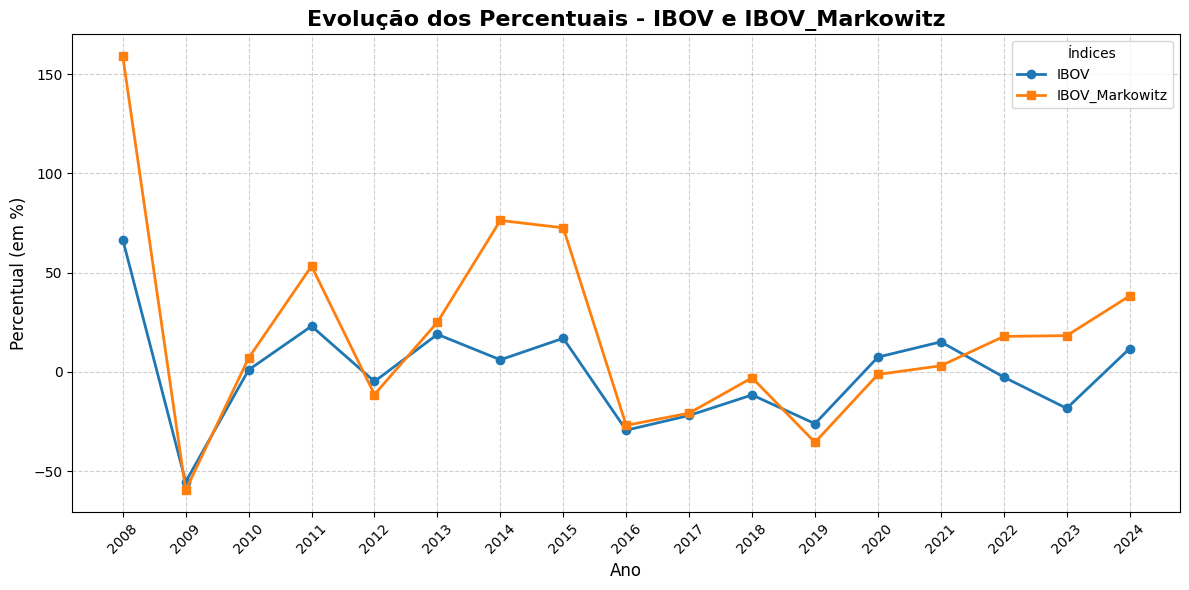

In [40]:
import matplotlib.pyplot as plt


# Criando o gráfico de linha para as colunas 'IBOV' e 'IBOV_1'
plt.figure(figsize=(12, 6))  # Tamanho do gráfico
plt.plot(df_carteira_agrupado.index.astype(str), df_carteira_agrupado['IBOV'], label='IBOV', marker='o', linestyle='-', color='#1f77b4', linewidth=2)
plt.plot(df_carteira_agrupado.index.astype(str), df_carteira_agrupado['IBOV_Markowitz'], label='IBOV_Markowitz', marker='s', linestyle='-', color='#ff7f0e', linewidth=2)

# Personalizando o gráfico
plt.title('Evolução dos Percentuais - IBOV e IBOV_Markowitz', fontsize=16, fontweight='bold')  # Título
plt.xlabel('Ano', fontsize=12)  # Rótulo do eixo X
plt.ylabel('Percentual (em %)', fontsize=12)  # Rótulo do eixo Y

# Rotacionando os rótulos do eixo X para facilitar a leitura
plt.xticks(rotation=45)

# Adicionando uma legenda
plt.legend(title='Índices', loc='upper right')

# Adicionando um grid para melhor visualização
plt.grid(True, linestyle='--', alpha=0.6)

# Exibindo o gráfico
plt.tight_layout()  # Ajusta o layout para não cortar partes do gráfico
plt.show()

**Comentários**

É possível observar como os cálculos estão sendo validados: a linha laranja indica que a carteira selecionada apresenta uma rentabilidade superior ao longo do período analisado. Apesar de, entre 2019 e 2021, o IBOV ter demonstrado um desempenho ainda mais rentável, fora desse intervalo a carteira superou o índice.

Em relação ao risco, nota-se que a carteira é bastante volátil. Há momentos de ganhos expressivos, mas também de perdas significativas. Essa volatilidade está diretamente associada ao risco, conforme previamente calculado. O principal objetivo, no entanto, era identificar uma carteira com rentabilidade superior ao IBOV — e há evidências de que isso foi alcançado.

É importante destacar que o conceito de "melhor" carteira é relativo. Investidores com perfil mais conservador, que priorizam menor volatilidade ou menor risco, possivelmente não considerariam essa carteira como ideal. Ainda assim, a relação entre retorno e risco (medida pelo índice de Sharpe) é mais favorável nesta carteira do que no IBOV, considerando o período de 2008 a 2024.

In [41]:
# Salvando a carteira
df_carteiras_ibov.to_csv('data/Carteiras_IBOV.csv', encoding='ISO-8859-1', index=False)

## 4.2. Tentando melhorar ainda mais esta carteira

Foi mencionado anteriormente que a quantidade de possibilidades envolvendo ativos pode impactar o gráfico de risco versus retorno. No caso anterior, o gráfico não apresentou uma curva característica da fronteira eficiente, mas sim um comportamento mais linear. Originalmente, a carteira do IBOV era composta por 53 ativos, número que foi reduzido para 10. Surge então uma nova questão: o que aconteceria ao filtrar ainda mais os ativos?

Ao calcular o risco, a correlação ou a covariância entre os ativos é um fator relevante. Considerando que a busca bayesiana é uma técnica de aprendizado de máquina (*machine learning*), é plausível que, ao buscar a maximização do Índice de Sharpe, o algoritmo tenha identificado que ativos com alta correlação entre si tendem a aumentar a volatilidade da carteira, o que por sua vez reduz o Índice de Sharpe. Dessa forma, é provável que a busca tenha, implicitamente, selecionado ativos menos correlacionados entre si.

Contudo, como não se pode afirmar com certeza que essa consideração foi feita de forma “intencional”, será aplicado agora um filtro explícito para eliminar ativos altamente correlacionados. Para isso, será calculada a média absoluta das correlações de cada ativo com os demais. Em seguida, será obtida a média dessas médias, que servirá como critério de corte.

Diferentemente do uso da mediana, que reduziria automaticamente a quantidade de ativos pela metade, o uso da média como critério visa apenas remover os ativos mais altamente correlacionados, sem impor uma redução específica na quantidade total. A escolha pela média, portanto, permite respeitar as características reais da distribuição das correlações, incluindo valores discrepantes que podem representar situações relevantes para a análise.

In [42]:
# Visualizar a correlação entre os ativos escolhidos
df_corr = df_percentual_ativos_escolhidos.corr().round(2)

display(df_corr)

Ativo,B3SA3,ENEV3,GOAU4,USIM5,PCAR3,EQTL3,BEEF3,BRKM5,ELET3,BBDC4
Ativo,,,,,,,,,,
B3SA3,1.00,0.15,0.30,0.28,0.04,0.08,0.18,0.22,0.28,0.32
ENEV3,0.15,1.00,0.20,0.20,0.05,0.07,0.17,0.19,0.21,0.18
GOAU4,0.30,0.20,1.00,0.68,0.03,0.09,0.27,0.39,0.38,0.43
USIM5,0.28,0.20,0.68,1.00,0.04,0.06,0.24,0.35,0.37,0.37
PCAR3,0.04,0.05,0.03,0.04,1.00,0.02,0.09,0.06,0.03,0.05
EQTL3,0.08,0.07,0.09,0.06,0.02,1.00,0.07,0.07,0.12,0.10
BEEF3,0.18,0.17,0.27,0.24,0.09,0.07,1.00,0.22,0.19,0.20
BRKM5,0.22,0.19,0.39,0.35,0.06,0.07,0.22,1.00,0.30,0.34
ELET3,0.28,0.21,0.38,0.37,0.03,0.12,0.19,0.30,1.00,0.39


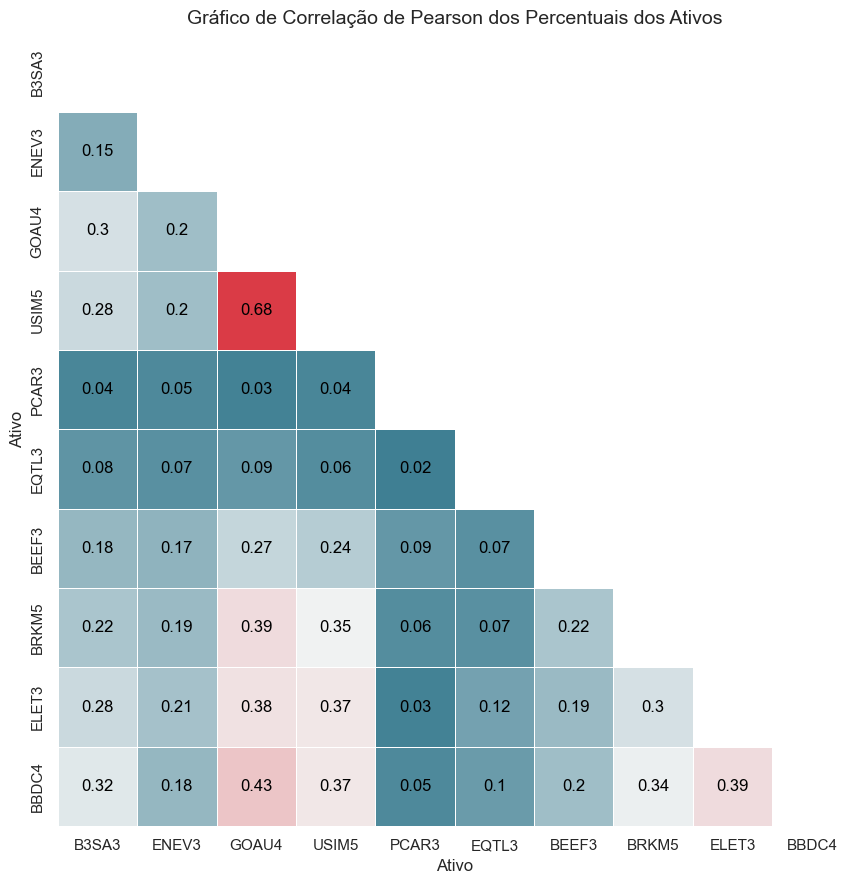

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Setando o estilo do gráfico
sns.set_theme(style="white")

# Gera a máscara para o triângulo superior
mask = np.triu(np.ones_like(df_corr, dtype=bool))

# Tamanho da figura
f, ax = plt.subplots(figsize=(18, 9))

# Paleta de cores mais contrastante
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Plotando o gráfico de correlação
sns.heatmap(
    df_corr,
    mask=mask,
    cmap=cmap,
    annot=True,
    annot_kws={"color": "black"},  # Anotações em preto
    square=True,
    linewidths=.5,
    cbar=False
)

ax.set_title("Gráfico de Correlação de Pearson dos Percentuais dos Ativos", fontsize=14)

plt.tight_layout()
plt.show()

In [44]:
# Exemplo: matriz de correlação
corr_matrix = df_corr.copy()

# Zerar a diagonal principal (correlação de uma variável com ela mesma = 1)
np.fill_diagonal(corr_matrix.values, np.nan)

# Calcular a média das correlações absolutas para cada variável
mean_abs_corr = corr_matrix.abs().mean()

# Identificar a variável com menor correlação média com as outras
least_correlated_variable = mean_abs_corr.idxmin()

# Visualizando
display(mean_abs_corr.sort_values(ascending=True).round(2))

Ativo
PCAR3    0.05
EQTL3    0.08
ENEV3    0.16
BEEF3    0.18
B3SA3    0.21
BRKM5    0.24
ELET3    0.25
BBDC4    0.26
USIM5    0.29
GOAU4    0.31
dtype: float64

In [45]:
# Mostrando a média das correlações
print(f'Média de corte: {mean_abs_corr.mean().round(2)}')


# Filtrando os ativos
ativos_filtrados = mean_abs_corr[mean_abs_corr.round(2) < mean_abs_corr.mean().round(2)]

print(f'\nAtivos filtrados ({len(ativos_filtrados)} ativos):')
print(ativos_filtrados.round(2))

Média de corte: 0.2

Ativos filtrados (4 ativos):
Ativo
ENEV3    0.16
PCAR3    0.05
EQTL3    0.08
BEEF3    0.18
dtype: float64


In [46]:
# Filtrando os ativos só de 2008
df_comp_teste = df_participacao[df_participacao['Ativo'].isin(ativos_filtrados.index)].copy().reset_index(drop=True)


# Visualizando as alterações
display(df_comp_teste)

,Ativo,Ano Fundacao,Ano IPO,Valor Mercado,Setor,Segmento,Idade,Tempo em Bolsa,Peso Participacao,EmpresaIPO,ClassEmpresa
0,EQTL3,1999,2006,40450120000,Utilidade Pública,Energia Elétrica,26,19,1.921,Normal,Mid Caps
1,ENEV3,2001,2007,18762819000,Utilidade Pública,Energia Elétrica,24,18,1.093,Normal,Mid Caps
2,BEEF3,1992,2007,3795521000,Consumo não Cíclico,Carnes e Derivados,33,18,0.079,Normal,Small Caps
3,PCAR3,1981,1995,1490138000,Consumo não Cíclico,Alimentos,44,30,0.068,Consolidada,Small Caps


**Comentários**

Até o momento, a carteira era composta por 53 ativos, posteriormente reduzida para 10, e agora, após a exclusão dos ativos altamente correlacionados entre si, restam 4 ativos.

Diante dessa nova composição, torna-se oportuno realizar novamente a busca bayesiana, considerando que a redução significativa no número de ativos também reduz o espaço de possibilidades das carteiras. Essa diminuição pode favorecer a formação de uma curva mais clara no gráfico de risco versus retorno, aproximando-se da fronteira eficiente preconizada pela teoria de Markowitz.

Portanto, será repetida a busca bayesiana utilizando apenas esses 4 ativos, previamente selecionados pela própria busca e, em seguida, filtrados com base nas correlações. O objetivo é refinar ainda mais a carteira, buscando uma composição com melhor desempenho ajustado ao risco.


### 4.2.2. Busca Bayesiana da Carteira Escolhida

In [47]:
# Algumas Configuracoes de arredondamento
arredondamento_pesos = 1
arredondamento_pesos_completos = 4

qtd_ativos = len(ativos_filtrados)

In [48]:
# Garantindo a semente de aleatoriedade
np.random.seed(42)

# Espaço com 4 ativos possíveis, todos com peso entre 0.01 e 1.0
dimensao = [Real(0.01, 1.0) for _ in range(qtd_ativos)]

In [49]:
# Criando um dataframe para analise
df_melhorando_markowitz = pd.DataFrame(columns=['Pesos_Sorteados', 'Rentabilidade', 'Risco', 'Retorno/Risco', 'Sharpe'])

def funcao_objetivo_melhorando_carteira(params):
    
    pesos = [round(p, arredondamento_pesos) for p in params]
    pesos_completos = pesos / np.sum(pesos)
    
    if np.isnan(pesos_completos).any():
        return 1000.0


    print(f'===================================> Soma dos Pesos: {pesos_completos.sum().round(arredondamento_pesos_completos)}')
    print(f'===================================> Pesos Ordenados: {np.sort(pesos_completos)[::-1].round(arredondamento_pesos_completos)}')

    # colocando os novos pesos sorteados
    df_comp_teste['Peso Participacao'] = pesos_completos
    df_comp_teste['Peso Participacao'] = df_comp_teste['Peso Participacao'].round(arredondamento_pesos_completos)

    # Criando o calculo da rentabilidade
    df_calculos, rentabilidade = calcula_rentabilidade_carteira (df_percentual_ativos[ativos_filtrados.index], df_participacao = df_comp_teste, coluna_peso='Peso Participacao')

    # Calculando os riscos
    df_calculos, risco = calcula_risco_carteira (df_calculos, df_percentual_ativos[ativos_filtrados.index])

    print(f' -------------------> Retorno Ponderado Anualizado na Carteira do IBOV: {rentabilidade.round(4) * 100}%')
    print(f' -------------------> Risco Ponderado Anualizado na Carteira do IBOV: {risco.round(4) * 100}%')

    # Calculo do retorno-risco
    sharpe = (rentabilidade - 0.058) / risco
    retorno_risco = rentabilidade / risco

    registro_peso = [', '.join(map(str, pesos_completos))] * len(df_comp_teste)

    # Criando o dicionário com as chaves e valores
    novo_registro = {'Pesos_Sorteados': registro_peso, 'Rentabilidade': rentabilidade, 
                        'Risco': risco, 'Retorno/Risco': retorno_risco, 'Sharpe': sharpe}

    # Transformando o registro em um DataFrame
    df_novo_registro = pd.DataFrame(novo_registro)

    # Definindo uma variavel global o dataframe
    global df_melhorando_markowitz

    # Criando uma nova linha no dataframe
    df_melhorando_markowitz = pd.concat([df_melhorando_markowitz, df_novo_registro], ignore_index=True)

    df_melhorando_markowitz = df_melhorando_markowitz.drop_duplicates()

    return -sharpe

In [50]:
%%time
# Executando a otimização
resultado_busca = gp_minimize(funcao_objetivo_melhorando_carteira, dimensao, n_calls=300, n_random_starts=20, random_state=42, verbose=1)

Iteration No: 1 started. Evaluating function at random point.
===================================> Soma dos Pesos: 1.0
===================================> Pesos Ordenados: [0.3333 0.3333 0.25   0.0833]
 -------------------> Retorno Ponderado Anualizado na Carteira do IBOV: 16.45%
 -------------------> Risco Ponderado Anualizado na Carteira do IBOV: 42.07%
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0089
Function value obtained: -0.2532
Current minimum: -0.2532
Iteration No: 2 started. Evaluating function at random point.
===================================> Soma dos Pesos: 1.0
===================================> Pesos Ordenados: [0.3571 0.3571 0.2143 0.0714]
 -------------------> Retorno Ponderado Anualizado na Carteira do IBOV: 16.04%
 -------------------> Risco Ponderado Anualizado na Carteira do IBOV: 43.4%
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0060
Function value obtained: -0.2360
Current minimum: -0.2532
Iteration No: 3 s

Iteration No: 20 ended. Evaluation done at random point.
Time taken: 0.1973
Function value obtained: -0.4350
Current minimum: -0.5511
Iteration No: 21 started. Searching for the next optimal point.
===================================> Soma dos Pesos: 1.0
===================================> Pesos Ordenados: [0.5882 0.4118 0.     0.    ]
 -------------------> Retorno Ponderado Anualizado na Carteira do IBOV: 22.17%
 -------------------> Risco Ponderado Anualizado na Carteira do IBOV: 35.94%
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.2017
Function value obtained: -0.4555
Current minimum: -0.5511
Iteration No: 22 started. Searching for the next optimal point.
===================================> Soma dos Pesos: 1.0
===================================> Pesos Ordenados: [0.6364 0.3636 0.     0.    ]
 -------------------> Retorno Ponderado Anualizado na Carteira do IBOV: 29.53%
 -------------------> Risco Ponderado Anualizado na Carteira do IBOV: 42.72%

Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 0.2370
Function value obtained: -0.5846
Current minimum: -0.5911
Iteration No: 38 started. Searching for the next optimal point.
===================================> Soma dos Pesos: 1.0
===================================> Pesos Ordenados: [0.8333 0.0833 0.0833 0.    ]
 -------------------> Retorno Ponderado Anualizado na Carteira do IBOV: 33.050000000000004%
 -------------------> Risco Ponderado Anualizado na Carteira do IBOV: 46.489999999999995%
Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 0.1987
Function value obtained: -0.5862
Current minimum: -0.5911
Iteration No: 39 started. Searching for the next optimal point.
===================================> Soma dos Pesos: 1.0
===================================> Pesos Ordenados: [0.7143 0.1429 0.0714 0.0714]
 -------------------> Retorno Ponderado Anualizado na Carteira do IBOV: 30.45%
 -------------------> Risco Ponderado A

Iteration No: 54 ended. Search finished for the next optimal point.
Time taken: 0.3628
Function value obtained: -0.2212
Current minimum: -0.5922
Iteration No: 55 started. Searching for the next optimal point.
===================================> Soma dos Pesos: 1.0
===================================> Pesos Ordenados: [0.3704 0.3704 0.2593 0.    ]
 -------------------> Retorno Ponderado Anualizado na Carteira do IBOV: 22.54%
 -------------------> Risco Ponderado Anualizado na Carteira do IBOV: 33.51%
Iteration No: 55 ended. Search finished for the next optimal point.
Time taken: 0.3208
Function value obtained: -0.4995
Current minimum: -0.5922
Iteration No: 56 started. Searching for the next optimal point.
===================================> Soma dos Pesos: 1.0
===================================> Pesos Ordenados: [0.5 0.5 0.  0. ]
 -------------------> Retorno Ponderado Anualizado na Carteira do IBOV: 26.950000000000003%
 -------------------> Risco Ponderado Anualizado na Carteira do 

Iteration No: 71 ended. Search finished for the next optimal point.
Time taken: 0.5429
Function value obtained: -0.2767
Current minimum: -0.5922
Iteration No: 72 started. Searching for the next optimal point.
===================================> Soma dos Pesos: 1.0
===================================> Pesos Ordenados: [0.3333 0.3333 0.3    0.0333]
 -------------------> Retorno Ponderado Anualizado na Carteira do IBOV: 15.509999999999998%
 -------------------> Risco Ponderado Anualizado na Carteira do IBOV: 43.09%
Iteration No: 72 ended. Search finished for the next optimal point.
Time taken: 0.4745
Function value obtained: -0.2253
Current minimum: -0.5922
Iteration No: 73 started. Searching for the next optimal point.
===================================> Soma dos Pesos: 1.0
===================================> Pesos Ordenados: [0.2857 0.2857 0.2857 0.1429]
 -------------------> Retorno Ponderado Anualizado na Carteira do IBOV: 20.66%
 -------------------> Risco Ponderado Anualizado na 

Iteration No: 88 ended. Search finished for the next optimal point.
Time taken: 0.6966
Function value obtained: -0.3174
Current minimum: -0.5922
Iteration No: 89 started. Searching for the next optimal point.
===================================> Soma dos Pesos: 1.0
===================================> Pesos Ordenados: [0.3448 0.3448 0.2759 0.0345]
 -------------------> Retorno Ponderado Anualizado na Carteira do IBOV: 20.02%
 -------------------> Risco Ponderado Anualizado na Carteira do IBOV: 42.89%
Iteration No: 89 ended. Search finished for the next optimal point.
Time taken: 0.6626
Function value obtained: -0.3314
Current minimum: -0.5922
Iteration No: 90 started. Searching for the next optimal point.
===================================> Soma dos Pesos: 1.0
===================================> Pesos Ordenados: [0.5294 0.4706 0.     0.    ]
 -------------------> Retorno Ponderado Anualizado na Carteira do IBOV: 27.500000000000004%
 -------------------> Risco Ponderado Anualizado na 

Iteration No: 105 ended. Search finished for the next optimal point.
Time taken: 0.7359
Function value obtained: -0.3256
Current minimum: -0.5922
Iteration No: 106 started. Searching for the next optimal point.
===================================> Soma dos Pesos: 1.0
===================================> Pesos Ordenados: [0.875 0.125 0.    0.   ]
 -------------------> Retorno Ponderado Anualizado na Carteira do IBOV: 19.84%
 -------------------> Risco Ponderado Anualizado na Carteira do IBOV: 58.699999999999996%
Iteration No: 106 ended. Search finished for the next optimal point.
Time taken: 0.8352
Function value obtained: -0.2392
Current minimum: -0.5922
Iteration No: 107 started. Searching for the next optimal point.
===================================> Soma dos Pesos: 1.0
===================================> Pesos Ordenados: [0.8889 0.1111 0.     0.    ]
 -------------------> Retorno Ponderado Anualizado na Carteira do IBOV: 19.580000000000002%
 -------------------> Risco Ponderado A

Iteration No: 122 ended. Search finished for the next optimal point.
Time taken: 1.0843
Function value obtained: -0.2830
Current minimum: -0.5922
Iteration No: 123 started. Searching for the next optimal point.
===================================> Soma dos Pesos: 1.0
===================================> Pesos Ordenados: [0.5882 0.3529 0.0588 0.    ]
 -------------------> Retorno Ponderado Anualizado na Carteira do IBOV: 22.68%
 -------------------> Risco Ponderado Anualizado na Carteira do IBOV: 63.0%
Iteration No: 123 ended. Search finished for the next optimal point.
Time taken: 1.0219
Function value obtained: -0.2680
Current minimum: -0.5922
Iteration No: 124 started. Searching for the next optimal point.
===================================> Soma dos Pesos: 1.0
===================================> Pesos Ordenados: [0.4762 0.2857 0.2381 0.    ]
 -------------------> Retorno Ponderado Anualizado na Carteira do IBOV: 20.79%
 -------------------> Risco Ponderado Anualizado na Carteira d

Iteration No: 139 ended. Search finished for the next optimal point.
Time taken: 1.3225
Function value obtained: -0.5896
Current minimum: -0.5922
Iteration No: 140 started. Searching for the next optimal point.
===================================> Soma dos Pesos: 1.0
===================================> Pesos Ordenados: [0.7692 0.2308 0.     0.    ]
 -------------------> Retorno Ponderado Anualizado na Carteira do IBOV: 19.919999999999998%
 -------------------> Risco Ponderado Anualizado na Carteira do IBOV: 78.39%
Iteration No: 140 ended. Search finished for the next optimal point.
Time taken: 1.2766
Function value obtained: -0.1801
Current minimum: -0.5922
Iteration No: 141 started. Searching for the next optimal point.
===================================> Soma dos Pesos: 1.0
===================================> Pesos Ordenados: [0.4348 0.4348 0.1304 0.    ]
 -------------------> Retorno Ponderado Anualizado na Carteira do IBOV: 14.09%
 -------------------> Risco Ponderado Anualizado

Iteration No: 156 ended. Search finished for the next optimal point.
Time taken: 1.4426
Function value obtained: -0.3647
Current minimum: -0.5922
Iteration No: 157 started. Searching for the next optimal point.
===================================> Soma dos Pesos: 1.0
===================================> Pesos Ordenados: [0.3333 0.3333 0.2333 0.1   ]
 -------------------> Retorno Ponderado Anualizado na Carteira do IBOV: 19.3%
 -------------------> Risco Ponderado Anualizado na Carteira do IBOV: 41.42%
Iteration No: 157 ended. Search finished for the next optimal point.
Time taken: 1.5593
Function value obtained: -0.3259
Current minimum: -0.5922
Iteration No: 158 started. Searching for the next optimal point.
===================================> Soma dos Pesos: 1.0
===================================> Pesos Ordenados: [0.3846 0.3462 0.2692 0.    ]
 -------------------> Retorno Ponderado Anualizado na Carteira do IBOV: 20.54%
 -------------------> Risco Ponderado Anualizado na Carteira d

Iteration No: 172 ended. Search finished for the next optimal point.
Time taken: 1.7416
Function value obtained: -0.2644
Current minimum: -0.5922
Iteration No: 173 started. Searching for the next optimal point.
===================================> Soma dos Pesos: 1.0
===================================> Pesos Ordenados: [0.2564 0.2564 0.2564 0.2308]
 -------------------> Retorno Ponderado Anualizado na Carteira do IBOV: 19.85%
 -------------------> Risco Ponderado Anualizado na Carteira do IBOV: 37.53%
Iteration No: 173 ended. Search finished for the next optimal point.
Time taken: 1.7783
Function value obtained: -0.3743
Current minimum: -0.5922
Iteration No: 174 started. Searching for the next optimal point.
===================================> Soma dos Pesos: 1.0
===================================> Pesos Ordenados: [0.5556 0.3889 0.0556 0.    ]
 -------------------> Retorno Ponderado Anualizado na Carteira do IBOV: 21.91%
 -------------------> Risco Ponderado Anualizado na Carteira 

Iteration No: 188 ended. Search finished for the next optimal point.
Time taken: 2.2247
Function value obtained: -0.5197
Current minimum: -0.5922
Iteration No: 189 started. Searching for the next optimal point.
===================================> Soma dos Pesos: 1.0
===================================> Pesos Ordenados: [0.5882 0.2941 0.1176 0.    ]
 -------------------> Retorno Ponderado Anualizado na Carteira do IBOV: 21.57%
 -------------------> Risco Ponderado Anualizado na Carteira do IBOV: 62.4%
Iteration No: 189 ended. Search finished for the next optimal point.
Time taken: 2.1376
Function value obtained: -0.2527
Current minimum: -0.5922
Iteration No: 190 started. Searching for the next optimal point.
===================================> Soma dos Pesos: 1.0
===================================> Pesos Ordenados: [0.3704 0.3704 0.2593 0.    ]
 -------------------> Retorno Ponderado Anualizado na Carteira do IBOV: 23.56%
 -------------------> Risco Ponderado Anualizado na Carteira d

Iteration No: 204 ended. Search finished for the next optimal point.
Time taken: 2.6857
Function value obtained: -0.4275
Current minimum: -0.5922
Iteration No: 205 started. Searching for the next optimal point.
===================================> Soma dos Pesos: 1.0
===================================> Pesos Ordenados: [0.8333 0.1667 0.     0.    ]
 -------------------> Retorno Ponderado Anualizado na Carteira do IBOV: 20.630000000000003%
 -------------------> Risco Ponderado Anualizado na Carteira do IBOV: 56.38999999999999%
Iteration No: 205 ended. Search finished for the next optimal point.
Time taken: 2.6767
Function value obtained: -0.2630
Current minimum: -0.5922
Iteration No: 206 started. Searching for the next optimal point.
===================================> Soma dos Pesos: 1.0
===================================> Pesos Ordenados: [0.3571 0.3571 0.25   0.0357]
 -------------------> Retorno Ponderado Anualizado na Carteira do IBOV: 15.370000000000001%
 -------------------> R

Iteration No: 221 ended. Search finished for the next optimal point.
Time taken: 2.6999
Function value obtained: -0.3077
Current minimum: -0.5922
Iteration No: 222 started. Searching for the next optimal point.
===================================> Soma dos Pesos: 1.0
===================================> Pesos Ordenados: [0.6667 0.2    0.1333 0.    ]
 -------------------> Retorno Ponderado Anualizado na Carteira do IBOV: 18.33%
 -------------------> Risco Ponderado Anualizado na Carteira do IBOV: 68.84%
Iteration No: 222 ended. Search finished for the next optimal point.
Time taken: 2.9601
Function value obtained: -0.1820
Current minimum: -0.5922
Iteration No: 223 started. Searching for the next optimal point.
===================================> Soma dos Pesos: 1.0
===================================> Pesos Ordenados: [0.5263 0.3684 0.1053 0.    ]
 -------------------> Retorno Ponderado Anualizado na Carteira do IBOV: 18.15%
 -------------------> Risco Ponderado Anualizado na Carteira 

Iteration No: 237 ended. Search finished for the next optimal point.
Time taken: 3.1747
Function value obtained: -0.5468
Current minimum: -0.5922
Iteration No: 238 started. Searching for the next optimal point.
===================================> Soma dos Pesos: 1.0
===================================> Pesos Ordenados: [0.3125 0.3125 0.2813 0.0938]
 -------------------> Retorno Ponderado Anualizado na Carteira do IBOV: 20.369999999999997%
 -------------------> Risco Ponderado Anualizado na Carteira do IBOV: 40.36%
Iteration No: 238 ended. Search finished for the next optimal point.
Time taken: 3.2220
Function value obtained: -0.3610
Current minimum: -0.5922
Iteration No: 239 started. Searching for the next optimal point.
===================================> Soma dos Pesos: 1.0
===================================> Pesos Ordenados: [0.6 0.4 0.  0. ]
 -------------------> Retorno Ponderado Anualizado na Carteira do IBOV: 28.84%
 -------------------> Risco Ponderado Anualizado na Carteira

Iteration No: 254 ended. Search finished for the next optimal point.
Time taken: 4.1717
Function value obtained: -0.1773
Current minimum: -0.5922
Iteration No: 255 started. Searching for the next optimal point.
===================================> Soma dos Pesos: 1.0
===================================> Pesos Ordenados: [0.75 0.25 0.   0.  ]
 -------------------> Retorno Ponderado Anualizado na Carteira do IBOV: 22.21%
 -------------------> Risco Ponderado Anualizado na Carteira do IBOV: 52.14%
Iteration No: 255 ended. Search finished for the next optimal point.
Time taken: 4.0688
Function value obtained: -0.3147
Current minimum: -0.5922
Iteration No: 256 started. Searching for the next optimal point.
===================================> Soma dos Pesos: 1.0
===================================> Pesos Ordenados: [0.7692 0.1538 0.0769 0.    ]
 -------------------> Retorno Ponderado Anualizado na Carteira do IBOV: 17.0%
 -------------------> Risco Ponderado Anualizado na Carteira do IBOV: 

Iteration No: 271 ended. Search finished for the next optimal point.
Time taken: 4.8039
Function value obtained: -0.4366
Current minimum: -0.5922
Iteration No: 272 started. Searching for the next optimal point.
===================================> Soma dos Pesos: 1.0
===================================> Pesos Ordenados: [0.5263 0.4211 0.0526 0.    ]
 -------------------> Retorno Ponderado Anualizado na Carteira do IBOV: 15.690000000000001%
 -------------------> Risco Ponderado Anualizado na Carteira do IBOV: 37.69%
Iteration No: 272 ended. Search finished for the next optimal point.
Time taken: 4.6711
Function value obtained: -0.2624
Current minimum: -0.5922
Iteration No: 273 started. Searching for the next optimal point.
===================================> Soma dos Pesos: 1.0
===================================> Pesos Ordenados: [0.3704 0.3704 0.2593 0.    ]
 -------------------> Retorno Ponderado Anualizado na Carteira do IBOV: 22.54%
 -------------------> Risco Ponderado Anualizado

Iteration No: 288 ended. Search finished for the next optimal point.
Time taken: 4.5571
Function value obtained: -0.5210
Current minimum: -0.5922
Iteration No: 289 started. Searching for the next optimal point.
===================================> Soma dos Pesos: 1.0
===================================> Pesos Ordenados: [0.5 0.5 0.  0. ]
 -------------------> Retorno Ponderado Anualizado na Carteira do IBOV: 26.950000000000003%
 -------------------> Risco Ponderado Anualizado na Carteira do IBOV: 43.66%
Iteration No: 289 ended. Search finished for the next optimal point.
Time taken: 4.4132
Function value obtained: -0.4843
Current minimum: -0.5922
Iteration No: 290 started. Searching for the next optimal point.
===================================> Soma dos Pesos: 1.0
===================================> Pesos Ordenados: [0.625 0.375 0.    0.   ]
 -------------------> Retorno Ponderado Anualizado na Carteira do IBOV: 29.32%
 -------------------> Risco Ponderado Anualizado na Carteira do 

In [51]:
# Pegando a melhor composição dos pesos
pesos = [round(p, arredondamento_pesos) for p in resultado_busca.x]
pesos_completos = pesos / np.sum(pesos)

print(pesos_completos)

[0.07142857 0.71428571 0.07142857 0.14285714]


In [52]:
# Passando a composição de melhor indice sharpe
df_comp = df_comp_teste.copy()

# Colocando os pesos nos ativos
df_comp['Peso Participacao'] = pesos_completos.round(arredondamento_pesos_completos)

# Filtrando apenas ativos com peso
df_comp = df_comp[df_comp['Peso Participacao'] != 0]

# Organizando os dados por maior peso
df_comp = df_comp.sort_values(by='Peso Participacao', ascending=False)

# Resetando os indices
df_comp = df_comp.reset_index(drop=True)

print(f"Soma dos Pesos: {df_comp['Peso Participacao'].sum()}")

# Visualizando as alterações
display(df_comp)

Soma dos Pesos: 1.0


,Ativo,Ano Fundacao,Ano IPO,Valor Mercado,Setor,Segmento,Idade,Tempo em Bolsa,Peso Participacao,EmpresaIPO,ClassEmpresa
0,ENEV3,2001,2007,18762819000,Utilidade Pública,Energia Elétrica,24,18,0.7143,Normal,Mid Caps
1,PCAR3,1981,1995,1490138000,Consumo não Cíclico,Alimentos,44,30,0.1429,Consolidada,Small Caps
2,EQTL3,1999,2006,40450120000,Utilidade Pública,Energia Elétrica,26,19,0.0714,Normal,Mid Caps
3,BEEF3,1992,2007,3795521000,Consumo não Cíclico,Carnes e Derivados,33,18,0.0714,Normal,Small Caps


In [53]:
# Dataframe das fronteiras de eficiencia
df_melhorando_markowitz.sort_values(by='Sharpe', ascending=False).round(4)

,Pesos_Sorteados,Rentabilidade,Risco,Retorno/Risco,Sharpe
37,"0.07142857142857142, 0.7142857142857142, 0.071...",0.3045,0.4163,0.7315,0.5922
133,"0.0, 0.8333333333333334, 0.0, 0.16666666666666669",0.3326,0.4645,0.7161,0.5912
29,"0.07692307692307693, 0.6923076923076923, 0.076...",0.2999,0.4093,0.7328,0.5911
34,"0.07692307692307693, 0.7692307692307692, 0.0, ...",0.3185,0.4409,0.7225,0.5910
53,"0.0, 0.8, 0.0, 0.2",0.3263,0.4543,0.7183,0.5906
...,...,...,...,...,...
4,"0.5454545454545454, 0.0, 0.0, 0.45454545454545453",0.1610,0.6257,0.2574,0.1647
159,"0.5882352941176471, 0.0, 0.0, 0.4117647058823529",0.1600,0.6504,0.2459,0.1568
70,"0.7142857142857142, 0.07142857142857142, 0.0, ...",0.1703,0.7316,0.2329,0.1536
219,"0.7692307692307692, 0.07692307692307693, 0.0, ...",0.1700,0.7784,0.2184,0.1439


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


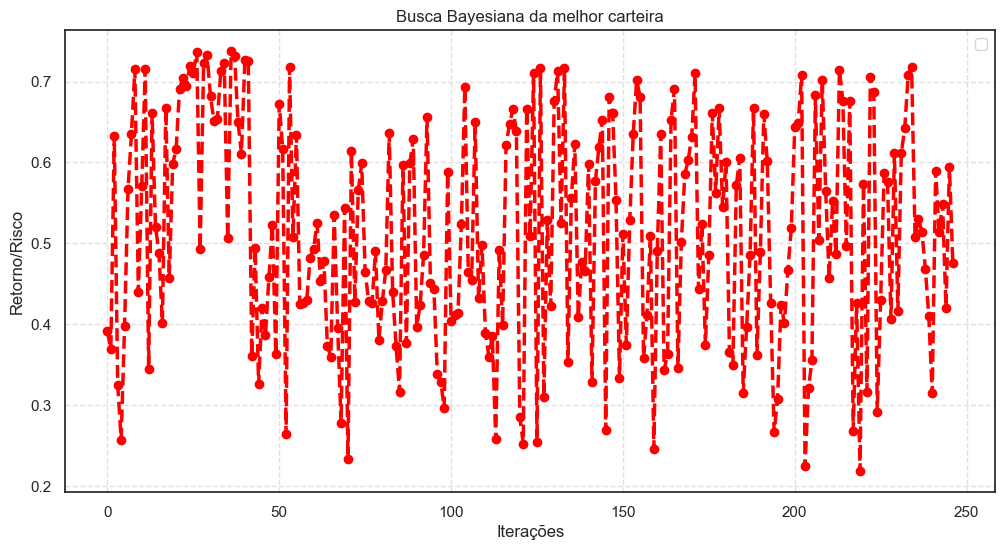

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

# Criando o gráfico de linha
plt.figure(figsize=(12, 6))
plt.plot(df_melhorando_markowitz.index, df_melhorando_markowitz["Retorno/Risco"], linestyle='--', marker='o', color='red', linewidth=2.5)

plt.title("Busca Bayesiana da melhor carteira")
plt.xlabel("Iterações")
plt.ylabel("Retorno/Risco")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

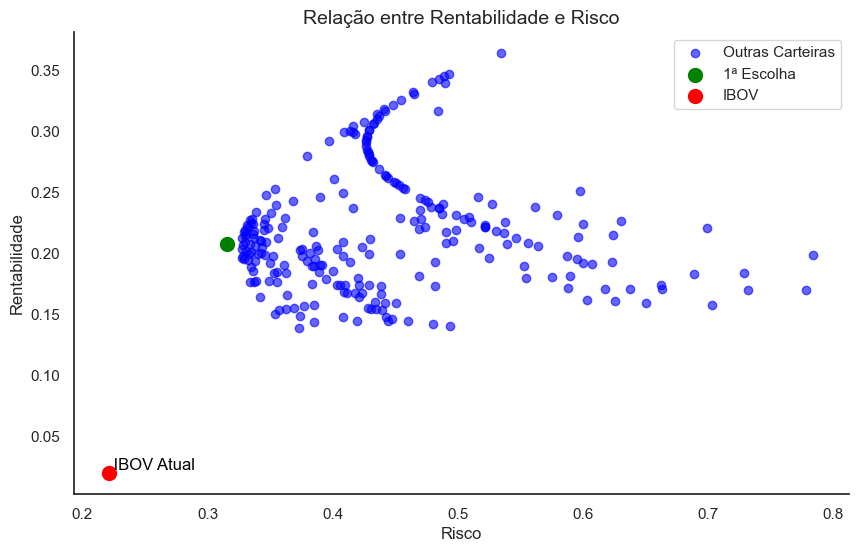

In [55]:
# Pegando os dados do DataFrame
x_risco = df_melhorando_markowitz["Risco"].values  # Eixo X (Risco)
y_retorno = df_melhorando_markowitz["Rentabilidade"].values  # Eixo Y (Retorno)

plt.figure(figsize=(10, 6))

# Scatter das carteiras
plt.scatter(x_risco, y_retorno, color="blue", label="Outras Carteiras", alpha=0.6)

# Adicionando ponto de destaque (IBOV)
destaque_x_2 = risco_markowitz
destaque_y_2 = rentabilidade_markowitz
plt.scatter(destaque_x_2, destaque_y_2, color='green', label="1ª Escolha", s=100, zorder=3)



# Adicionando ponto de destaque (IBOV)
destaque_x = risco_ibov
destaque_y = rentabilidade_ibov
plt.scatter(destaque_x, destaque_y, color='red', s=100, zorder=3, label="IBOV")
plt.text(destaque_x, destaque_y, " IBOV Atual", fontsize=12, verticalalignment='bottom', horizontalalignment='left', color='black')

# Títulos, eixos e legenda
plt.title("Relação entre Rentabilidade e Risco", fontsize=14)
plt.xlabel("Risco", fontsize=12)
plt.ylabel("Rentabilidade", fontsize=12)

# Plotando a legenda
plt.legend(fontsize=11)

# Removendo bordas superior e direita
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.show()


**Comentários**

No gráfico da busca bayesiana, observa-se que não houve uma evolução significativa nos resultados. O Índice de Sharpe, que representa a relação entre retorno e risco (ajustado pela média da inflação do período), não ultrapassou 70%. Mesmo após 300 interações, nenhuma carteira apresentou uma rentabilidade superior ao risco de forma consistente.

Contudo, ao considerar apenas os 4 ativos selecionados, o gráfico da relação entre Rentabilidade e Risco apresenta um comportamento mais alinhado com a teoria de Markowitz. É possível identificar duas curvas que representam a fronteira eficiente das carteiras compostas por esses ativos. Isso evidencia que, à medida que a rentabilidade aumenta, o risco também cresce — entretanto, carteiras com risco elevado não garantem, necessariamente, a maior rentabilidade.

O gráfico também permite a comparação entre as carteiras otimizadas, a composição atual do IBOV e a primeira carteira selecionada na etapa inicial da busca. Nota-se que a carteira do IBOV apresenta o menor risco entre todas, indicando menor volatilidade. Já a primeira carteira, embora com risco inferior às demais otimizadas, posiciona-se no centro do gráfico em termos de rentabilidade, sugerindo que sua composição era relativamente mais eficiente em termos de retorno para um nível de risco mais moderado.

### 4.2.1. Avaliando a carteira

In [56]:
# Olhando os percentuais
display(df_percentual_ativos)

Ativo,Date,ABEV3,B3SA3,BBAS3,BBDC3,BBDC4,BEEF3,BRAP4,BRFS3,BRKM5,CCRO3,CMIG4,CPFE3,CPLE6,CSAN3,CSNA3,CYRE3,EGIE3,ELET3,ELET6,EMBR3,ENEV3,EQTL3,GGBR4,GOAU4,HYPE3,ISAE4,ITSA4,ITUB4,JBSS3,LREN3,MRFG3,MRVE3,MULT3,PCAR3,PETR3,PETR4,POMO4,PSSA3,RADL3,RENT3,SBSP3,SLCE3,SMTO3,SUZB3,TAEE11,TIMS3,TOTS3,UGPA3,USIM5,VALE3,VIVT3,WEGE3,YDUQ3
0,2008-01-02,0.0144,0.0286,0.0209,0.0721,0.0000,0.0335,0.0000,0.0437,0.0211,-0.0194,0.0000,0.0120,0.0092,-0.0065,0.0164,0.0206,0.0388,0.0270,0.0000,0.0024,0.0223,0.0000,0.0000,0.0367,0.0000,0.0625,0.1438,0.0459,0.0081,0.0129,0.0010,-0.0113,0.0340,0.0000,0.0068,0.0161,0.0093,0.0440,0.1029,0.0601,-0.0116,0.0067,-0.0022,0.0000,0.0818,0.0000,-0.0139,0.0000,0.0000,0.0243,0.0471,0.0115,0.0000
1,2008-01-03,-0.0036,0.0107,0.0154,0.0110,0.0206,-0.0349,0.0333,-0.0045,0.0080,0.0256,0.0054,-0.0074,-0.0268,-0.0161,-0.0208,0.0093,0.0131,0.0088,0.0108,-0.0196,0.0066,0.0000,0.0000,-0.0233,0.0000,0.0000,0.0139,0.0187,0.0165,0.0131,-0.0010,0.0032,-0.0675,0.0000,0.0145,0.0164,0.0000,0.0236,-0.0145,-0.0394,-0.0271,0.0068,0.0022,0.0000,-0.0717,0.0000,-0.0035,0.0000,0.0074,-0.0051,0.0047,0.0000,0.0000
2,2008-01-04,0.0146,0.0891,0.0117,-0.0195,0.0123,0.0113,0.0420,0.0364,0.0429,0.0445,0.0222,0.0353,0.0467,0.0032,0.0332,0.0212,0.0000,0.0104,0.0065,0.0052,0.0204,0.0000,0.0000,0.0263,0.0000,0.0000,0.0035,-0.0072,0.0111,0.0160,0.0000,0.0282,0.0223,0.0000,0.0631,0.0517,-0.0092,0.0130,0.0147,0.0496,0.0195,-0.0199,-0.0085,0.0000,-0.0084,0.0316,0.0248,0.0000,0.0305,0.0374,0.0300,0.0039,0.0000
3,2008-01-07,0.0224,0.0546,-0.0229,-0.0107,-0.0186,0.0000,0.0092,-0.0308,-0.0137,-0.0232,-0.0055,0.0015,0.0000,-0.0578,0.0343,0.0000,-0.0629,-0.0125,-0.0171,0.0047,-0.0101,0.0000,0.0000,0.0277,0.0000,0.0000,0.0000,0.0000,0.0028,0.0621,0.0073,0.0361,0.0445,0.0000,0.0357,0.0308,0.0381,0.0132,0.0303,0.0401,0.0105,0.0067,-0.0526,0.0000,0.0042,0.0021,0.0483,0.0000,0.0509,0.0184,-0.0016,-0.0038,0.0000
4,2008-01-08,-0.0147,-0.0406,-0.0206,-0.0210,-0.0146,-0.0063,0.0000,-0.0022,-0.0014,-0.0336,0.0000,-0.0015,-0.0093,-0.0464,-0.0188,-0.0553,0.0187,-0.0007,-0.0021,-0.0023,0.0000,0.0000,0.0000,0.0070,0.0000,0.0000,-0.0103,-0.0092,0.0229,0.0412,-0.0031,-0.0068,-0.0126,0.0000,-0.0567,-0.0523,-0.0278,0.0202,0.0312,0.0295,-0.0023,0.0000,-0.0714,0.0000,0.0000,0.0000,0.0151,0.0000,0.0000,-0.0197,-0.0008,0.0277,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4205,2024-12-20,0.0446,-0.0276,-0.0079,-0.0224,-0.0215,-0.0018,0.0000,-0.0030,0.0328,-0.0173,-0.0215,-0.0157,-0.0096,-0.0270,-0.0054,-0.0217,-0.0133,-0.0114,-0.0171,0.0184,-0.0116,-0.0083,0.0063,-0.0055,-0.0446,-0.0156,-0.0156,-0.0112,0.0224,-0.0314,-0.0256,-0.0054,-0.0307,-0.0249,0.0073,0.0084,0.0259,0.0118,-0.0026,-0.0337,0.0066,0.0005,-0.0247,0.0181,-0.0175,-0.0087,-0.0022,-0.0158,0.0166,-0.0156,-0.0099,0.0165,-0.0460
4206,2024-12-23,0.0008,0.0010,0.0067,0.0159,0.0182,0.0184,0.0072,0.0123,0.0322,0.0266,0.0401,0.0387,0.0298,-0.0023,0.0497,0.0381,0.0337,0.0139,0.0160,-0.0106,0.0446,0.0424,0.0257,0.0417,-0.0321,0.0236,0.0134,0.0196,0.0081,0.0636,0.0084,0.0532,0.0371,-0.0082,-0.0075,-0.0003,0.0367,0.0105,0.0058,0.0243,-0.0201,0.0268,0.0427,-0.0265,0.0319,0.0066,-0.0047,0.0129,0.0363,-0.0042,0.0336,0.0225,0.0333
4207,2024-12-26,0.0067,-0.0069,-0.0116,-0.0108,-0.0081,0.0421,0.0012,0.0220,0.0017,-0.0039,-0.0129,-0.0060,-0.0033,0.0215,-0.0045,0.0135,0.0011,-0.0062,-0.0087,-0.0123,0.0028,0.0040,0.0027,0.0048,0.0267,-0.0009,-0.0108,-0.0064,0.0005,0.0033,-0.0101,-0.0150,0.0162,-0.0508,0.0188,0.0305,0.0014,0.0120,0.0036,0.0109,-0.0018,0.0119,0.0126,-0.0113,-0.0076,0.0193,0.0121,0.0227,-0.0095,-0.0028,-0.0079,-0.0077,0.0206
4208,2024-12-27,0.0059,-0.0029,0.0037,0.0069,0.0082,0.0077,0.0066,0.0270,0.0208,-0.0029,0.0009,-0.0019,-0.0087,0.0245,0.0253,-0.0018,0.0180,-0.0012,-0.0011,-0.0016,0.0180,0.0065,0.0203,0.0244,0.0074,0.0043,0.0073,0.0100,0.0

In [57]:
# Pegando os ativos escolhidos
lista_ativos_escolhidos = df_comp['Ativo'].tolist()

print(lista_ativos_escolhidos)

# Deixando o percentual apenas dos ativos escolhidos
df_percentual_ativos_escolhidos = df_percentual_ativos[lista_ativos_escolhidos]

# Visualizando
display(df_percentual_ativos_escolhidos)

['ENEV3', 'PCAR3', 'EQTL3', 'BEEF3']


Ativo,ENEV3,PCAR3,EQTL3,BEEF3
0,0.0223,0.0000,0.0000,0.0335
1,0.0066,0.0000,0.0000,-0.0349
2,0.0204,0.0000,0.0000,0.0113
3,-0.0101,0.0000,0.0000,0.0000
4,0.0000,0.0000,0.0000,-0.0063
...,...,...,...,...
4205,-0.0116,-0.0249,-0.0083,-0.0018
4206,0.0446,-0.0082,0.0424,0.0184
4207,0.0028,-0.0508,0.0040,0.0421
4208,0.0180,-0.0116,0.0065,0.0077


In [58]:
# criar um dataframe com ponderação dos percentuais
ativos_escolhidos_ponderados = pd.DataFrame(columns=df_percentual_ativos_escolhidos.columns) 

# Só é possivel devido a ordem dos ativos
for ativo in ativos_escolhidos_ponderados.columns:
    # Peso em decimal
    peso = df_comp[df_comp['Ativo'] == ativo]['Peso Participacao']
    peso = peso.iloc[0]
    # Multiplica o percentual de variação de abertura dos ativos
    ativos_escolhidos_ponderados[ativo] = df_percentual_ativos_escolhidos[ativo] * peso
    
# Visualizando as alterações
display(ativos_escolhidos_ponderados)

Ativo,ENEV3,PCAR3,EQTL3,BEEF3
0,0.015929,0.000000,0.000000,0.002392
1,0.004714,0.000000,0.000000,-0.002492
2,0.014572,0.000000,0.000000,0.000807
3,-0.007214,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,-0.000450
...,...,...,...,...
4205,-0.008286,-0.003558,-0.000593,-0.000129
4206,0.031858,-0.001172,0.003027,0.001314
4207,0.002000,-0.007259,0.000286,0.003006
4208,0.012857,-0.001658,0.000464,0.000550


In [59]:
# Passando a variação ponderada para este novo dataframe
df_carteiras_ibov['IBOV_Markowitz_Melhorado'] = ativos_escolhidos_ponderados.sum(axis=1)

# Visualizando o dataframe
display(df_carteiras_ibov)

,Date,Ano,IBOV,IBOV_Ponderado_1,IBOV_Markowitz,IBOV_Markowitz_Melhorado
0,2008-01-02,2008,0.017050,0.020113,0.018130,0.018321
1,2008-01-03,2008,-0.001224,0.003015,-0.000450,0.002223
2,2008-01-04,2008,0.030391,0.019889,0.031157,0.015379
3,2008-01-07,2008,0.004361,0.008060,0.019495,-0.007214
4,2008-01-08,2008,-0.021085,-0.011449,-0.006463,-0.000450
...,...,...,...,...,...,...
4205,2024-12-20,2024,-0.007486,-0.003938,-0.007323,-0.012565
4206,2024-12-23,2024,0.011054,0.007169,0.026893,0.035027
4207,2024-12-26,2024,-0.002569,0.001328,-0.004040,-0.001968
4208,2024-12-27,2024,0.006727,0.005817,0.007616,0.012214


In [60]:
# Criando o grupo de Mes e Ano, para nao ficar um gráfico com muita volatilidade
df_carteiras_ibov['Ano'] = df_carteiras_ibov['Date'].dt.to_period('Y')

# Agrupar por 'Ano' e somar os percentuais da coluna 'Part. (%)'
df_carteira_agrupado = df_carteiras_ibov.groupby('Ano')[['IBOV', 'IBOV_Markowitz', 'IBOV_Markowitz_Melhorado']].sum()*100

df_carteira_agrupado = df_carteira_agrupado.round(2)

# Visualizando o grupo
display(df_carteira_agrupado)

,IBOV,IBOV_Markowitz,IBOV_Markowitz_Melhorado
Ano,,,
2008,66.66,159.09,205.02
2009,-55.40,-59.61,-88.49
2010,0.99,6.95,-14.09
2011,23.03,53.27,-35.89
2012,-4.84,-11.41,6.20
2013,18.90,25.00,100.45
2014,6.07,76.27,173.33
2015,16.92,72.56,69.06
2016,-29.39,-26.94,33.99


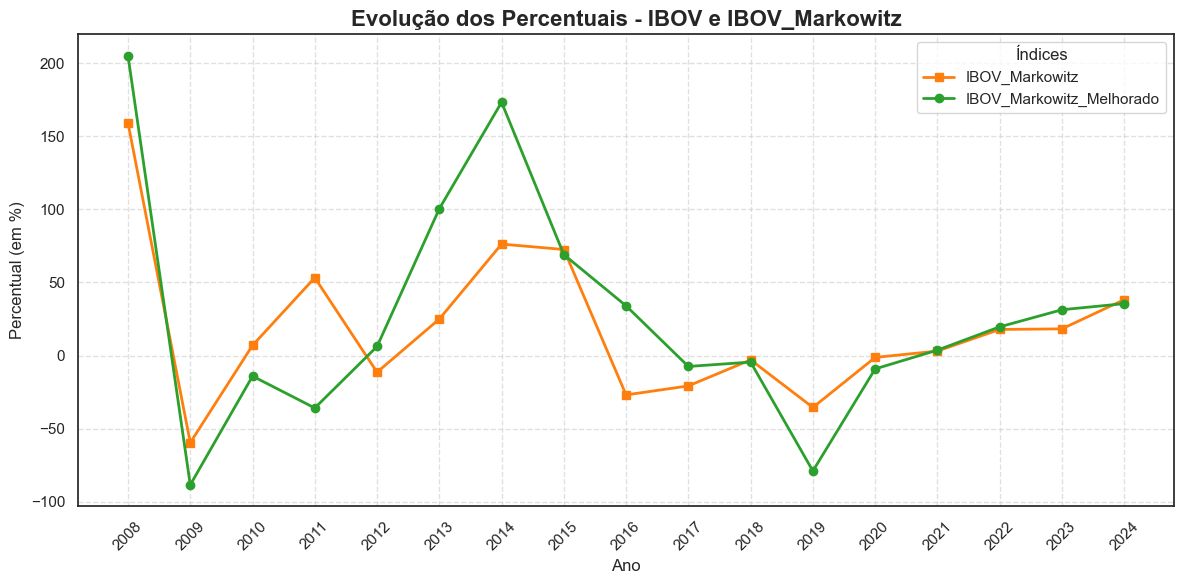

In [61]:
import matplotlib.pyplot as plt


# Criando o gráfico de linha para as colunas 'IBOV' e 'IBOV_1'
plt.figure(figsize=(12, 6))  # Tamanho do gráfico

plt.plot(df_carteira_agrupado.index.astype(str), df_carteira_agrupado['IBOV_Markowitz'], label='IBOV_Markowitz', marker='s', linestyle='-', color='#ff7f0e', linewidth=2)
plt.plot(df_carteira_agrupado.index.astype(str), df_carteira_agrupado['IBOV_Markowitz_Melhorado'], label='IBOV_Markowitz_Melhorado', marker='o', linestyle='-', color='#2ca02c', linewidth=2)  # vermelho

# Personalizando o gráfico
plt.title('Evolução dos Percentuais - IBOV e IBOV_Markowitz', fontsize=16, fontweight='bold')  # Título
plt.xlabel('Ano', fontsize=12)  # Rótulo do eixo X
plt.ylabel('Percentual (em %)', fontsize=12)  # Rótulo do eixo Y

# Rotacionando os rótulos do eixo X para facilitar a leitura
plt.xticks(rotation=45)

# Adicionando uma legenda
plt.legend(title='Índices', loc='upper right')

# Adicionando um grid para melhor visualização
plt.grid(True, linestyle='--', alpha=0.6)

# Exibindo o gráfico
plt.tight_layout()  # Ajusta o layout para não cortar partes do gráfico
plt.show()

In [62]:
# Salvando a carteira
df_carteiras_ibov.to_csv('data/Carteiras_IBOV.csv', encoding='ISO-8859-1', index=False)

**Comentários**

A linha laranja representa a primeira carteira selecionada, que apresentava algumas características distintas em relação ao IBOV. Essa carteira obteve lucros superiores, mas também esteve exposta a uma volatilidade maior. Serve, portanto, como parâmetro de comparação para a carteira otimizada mais recentemente.

Observa-se que a linha verde, que representa essa nova composição, apresenta uma rentabilidade significativamente superior, ainda que com mais períodos de desempenho abaixo do IBOV. Entre 2012 e 2014, essa carteira teve um rendimento expressivo, mantendo-se acima do IBOV até 2018, e voltando a se recuperar em 2021 até o período atual.

Esses resultados indicam evidências de um potencial de rendimento mais elevado em relação à versão anterior com 9 ativos. No entanto, essa carteira também apresentou maior volatilidade, com perdas mais frequentes e acentuadas, o que dificulta uma definição objetiva de "melhor" composição. Embora a carteira de 4 ativos (linha verde) possua alta expectativa de retorno, seu risco é consideravelmente maior. Assim, para perfis mais conservadores, a carteira do IBOV continua sendo uma alternativa mais adequada. Ainda assim, considerando a relação entre rentabilidade e risco — com a rentabilidade já ajustada pela inflação —, os resultados sugerem que a carteira de 9 ativos, e especialmente a nova composição com 4 ativos, oferecem uma performance mais eficiente.